<a href="https://colab.research.google.com/github/prithuls/Connected-Unets-and-more/blob/main/ConnectedUNet_MDoM_INbreast_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os, glob, cv2
from skimage.io import imsave
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, \
              Conv2D, Add, MaxPooling2D, Activation, add, \
              Conv2DTranspose, BatchNormalization, \
              GlobalAveragePooling2D, Reshape, Dense, Multiply
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
#from data import load_train_data, load_test_data
from sklearn.model_selection import train_test_split, KFold
K.set_image_data_format('channels_last')
from scipy.spatial.distance import directed_hausdorff

In [ ]:
## Configuration

full_dir_inbreast = '/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(INbreast)/Preprocessed_Full_MM'
mask_dir_inbreast = '/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(INbreast)/Preprocessed_Mask_Img'
extension = ".png"

target_size = 224

brightness_delta = 0.3

batch_size = 8
smooth = 1.

encoder_input_shape = (target_size, target_size, 3)
decoder_kernel_size = (3, 3)
decoder_strides = (2, 2)
decoder_padding = 'same'
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"
learning_rate = 0.0001

## **Helping Function**

In [ ]:
def checkLRFlip(mask):

    """
    This function checks whether or not an image needs to be
    flipped horizontally (i.e. left-right flip). The correct
    orientation is the breast being on the left (i.e. facing
    right).
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The corresponding mask of the image to flip.
    Returns
    -------
    LR_flip : {boolean}
        True means need to flip horizontally,
        False means otherwise.
    """

    try:
        # Get number of rows and columns in the image.
        nrows, ncols = mask.shape
        x_center = ncols // 2
        y_center = nrows // 2

        # Sum down each column.
        col_sum = mask.sum(axis=0)
        # Sum across each row.
        row_sum = mask.sum(axis=1)

        left_sum = sum(col_sum[0:x_center])
        right_sum = sum(col_sum[x_center:-1])

        if left_sum < right_sum:
            LR_flip = True
        else:
            LR_flip = False

    except Exception as e:
        # logger.error(f'Unable to checkLRFlip!\n{e}')
        print((f"Unable to get checkLRFlip!\n{e}"))

    return LR_flip

def makeLRFlip(img):

    """
    This function flips a given image horizontally (i.e. left-right).
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to flip.
    Returns
    -------
    flipped_img : {numpy.ndarray}
        The flipped image.
    """

    try:
        flipped_img = np.fliplr(img)
    except Exception as e:
        # logger.error(f'Unable to makeLRFlip!\n{e}')
        print((f"Unable to get makeLRFlip!\n{e}"))

    return flipped_img

## **Preprocessing**

In [ ]:
# **Preprocessing**

def datasetPaths_inbreast(full_img_dir, mask_img_dir, extension):

        """
        Follows the flow:
        1.         datasetPaths_inbreast() *
                 _______|_______
                |               |
        2. loadFullImg()  loadMaskImg()
                |_______________|
                        |
        3.          tfParse()
                        |
        4.         imgAugment()
                        |
        5.        makeTFDataset()
        Takes in the directories of the folder containing the full mammogram
        scans (x) and the ground truth masks (y) and returns a list of paths to
        individual full scans and masks.
        Parameters
        ----------
        full_img_dir : {str}
            Directory that contains the FULL training images.
        mask_img_dir : {str}
            Directory that contains the MASK training images.
        extension : {str}
            The file extension of the images (e.g. ".png")
        Returns
        -------
        x_paths_list: {list}
            A list of paths to individual FULL images in the training set.
        y_paths_list: {list}
            A list of paths to individual MASK images in the training set.
        """

        try:

            # =======================================
            #  1. Get paths of X (full) and y (mask)
            # =======================================

            x_paths_list = []
            y_paths_list = []

            files_mask = sorted(os.listdir(mask_img_dir))
            files_mm = sorted(os.listdir(full_img_dir))

            for file_1 in files_mask:
                #print(file[0:-9])
                temp = file_1[0:-9]
                for file_2 in files_mm:
                    if temp in file_2:
                        x_paths_list.append(os.path.join(full_img_dir, file_2))
                        y_paths_list.append(os.path.join(mask_img_dir, file_1))
                        #x_paths_list.append(file_2)
                        #y_paths_list.append(file_1)

            # full_img_ID = [fn[:26] for fn in sorted(os.listdir(full_img_dir))]
            # mask_img_ID = [fn[:26] for fn in sorted(os.listdir(mask_img_dir))]

            # full_dirs = [fn for fn in sorted(os.listdir(full_img_dir))]
            # mask_dirs = [fn for fn in sorted(os.listdir(mask_img_dir))]

            # ## Common Elements
            # common_ID_FullandMask = []
            # temp_mask_img_ID = mask_img_ID
            # for a_ in full_img_ID:
            #   for b_ in temp_mask_img_ID:
            #     if a_ == b_:
            #       common_ID_FullandMask.append(a_)
            #       temp_mask_img_ID.remove(b_)

            # temp_full_path, temp_mask_path = 0, 0 ## For checking if the 'Below function ifs' are picking anything

            # for i in range(len(common_ID_FullandMask)):
            #     for j in range(len(full_dirs)):
            #         fn_ = full_dirs[j]
            #         if common_ID_FullandMask[i] in fn_ and fn_.endswith(extension):
            #             temp_full_path = fn_
            #             break
            #     for k in range(len(mask_dirs)):
            #         fn_2 = mask_dirs[k]
            #         if common_ID_FullandMask[i] in fn_2 and fn_2.endswith(extension) :
            #             temp_mask_path = fn_2
            #             break
            #     if temp_full_path == 0 or temp_mask_path == 0:
            #         temp_full_path, temp_mask_path = 0, 0
            #         continue
                
            #     full_dirs.pop(j)
            #     mask_dirs.pop(k)
            #     x_paths_list.append(os.path.join(full_img_dir, temp_full_path))
            #     y_paths_list.append(os.path.join(mask_img_dir, temp_mask_path))

            #     temp_full_path, temp_mask_path = 0, 0 # Reasserting value to 0


            # print('x_paths_list length', len(x_paths_list))
            # print('y_paths_list length', len(y_paths_list))


            # # Get paths of train images and masks.
            # '''for full in os.listdir(full_img_dir):
            #     if full.endswith(extension):
            #         x_paths_list.append(os.path.join(full_img_dir, full))

            # for mask in os.listdir(mask_img_dir):
            #     if mask.endswith(extension):
            #         y_paths_list.append(os.path.join(mask_img_dir, mask))'''

            # # ** IMPORTANT ** Sort so that FULL and MASK images are in an order
            # # that corresponds with each other.
            # #x_paths_list.sort()
            # #y_paths_list.sort()

        except Exception as e:
            # logger.error(f'Unable to datasetPaths_inbreast!\n{e}')
            print((f"Unable to datasetPaths_inbreast!\n{e}"))

        return x_paths_list, y_paths_list


'''def datasetPaths_inbreast(full_img_dir, mask_img_dir, extension):

        """
        Follows the flow:
        1.         datasetPaths_inbreast() *
                 _______|_______
                |               |
        2. loadFullImg()  loadMaskImg()
                |_______________|
                        |
        3.          tfParse()
                        |
        4.         imgAugment()
                        |
        5.        makeTFDataset()
        Takes in the directories of the folder containing the full mammogram
        scans (x) and the ground truth masks (y) and returns a list of paths to
        individual full scans and masks.
        Parameters
        ----------
        full_img_dir : {str}
            Directory that contains the FULL training images.
        mask_img_dir : {str}
            Directory that contains the MASK training images.
        extension : {str}
            The file extension of the images (e.g. ".png")
        Returns
        -------
        x_paths_list: {list}
            A list of paths to individual FULL images in the training set.
        y_paths_list: {list}
            A list of paths to individual MASK images in the training set.
        """

        try:

            # =======================================
            #  1. Get paths of X (full) and y (mask)
            # =======================================

            x_paths_list = []
            y_paths_list = []

            # Get paths of train images and masks.
            for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))

            for mask in os.listdir(mask_img_dir):
                if mask.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, mask))

            # ** IMPORTANT ** Sort so that FULL and MASK images are in an order
            # that corresponds with each other.
            x_paths_list.sort()
            y_paths_list.sort()

        except Exception as e:
            # logger.error(f'Unable to datasetPaths_inbreast!\n{e}')
            print((f"Unable to datasetPaths_inbreast!\n{e}"))

        return x_paths_list, y_paths_list'''






def loadFullImg(path, dsize):

        """
        Takes in the path of a FULL image and loads it as a grayscale image (as
        a numpy array with 3 channels).
        Parameters
        ----------
        path : {str}
            The path of the FULL image.
        Returns
        -------
        full_img : {numpy.ndarray}
            The loaded image with shape = (self.target_size, self.target_size, 3)
        """

        try:
            # =====================================
            #  2a. Read images (full)
            # =====================================
            if not isinstance(path, str):
                path = path.decode()

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=(dsize, dsize))
            #print(np.shape(img))

            # Min max normalise to [0, 1].
            norm_img = (img - img.min()) / (img.max() - img.min())

            # Stack grayscale image to make channels=3.
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)

        except Exception as e:
            # logger.error(f'Unable to loadFullImg!\n{e}')
            print((f"Unable to loadFullImg!\n{e}"))

        return full_img

def loadMaskImg(path, dsize):

        """
        Takes in the path of a MASK image and loads it as a grayscale image (as
        a numpy array with 1 channel).
        Parameters
        ----------
        path : {str}
            The path of the MASK image.
        Returns
        -------
        full_img : {numpy.ndarray}
            The loaded image with shape = (self.target_size, self.target_size, 1)
        """

        try:

            # ========================
            #  2b. Read images (mask)
            # ========================
            if not isinstance(path, str):
                path = path.decode()

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=(dsize,dsize))
            #print(np.shape(img))

            # Min max normalise to [0, 1].
            norm_img = (img - img.min()) / (img.max() - img.min())

            # Expand shape to (width, height, 1).
            mask_img = np.expand_dims(norm_img, axis=-1)

        except Exception as e:
            # logger.error(f'Unable to loadMaskImg!\n{e}')
            print((f"Unable to loadMaskImg!\n{e}"))

        return mask_img

def tfParse(x_path, y_path):

        """
        Takes in a FULL image path and a MASK image path, loads the images using
        loadFullImg() and loadMaskImg() and makes it TensorFlow executable.
        Parameters
        ----------
        x_path: {str}
            The path of the FULL image to be loaded.
        y_path: {str}
            The path of the MASK image to be loaded.
        Returns
        -------
        x : {tensor}
            The FULL image loaded as a tensor with shape =
            (self.target_size, self.target_size, 3)
        y : {tensor}
            The MASK image loaded as a tensor with shape =
            (self.target_size, self.target_size, 1)
        """

        try:
            # ===========
            #  3. Parse
            # ===========
            def _parse(x_path, y_path):
                x = loadFullImg(path=x_path, dsize=target_size)
                y = loadMaskImg(path=y_path, dsize=target_size)
                return x, y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])

            x.set_shape([target_size, target_size, 3])
            y.set_shape([target_size, target_size, 1])


            return x, y

        except Exception as e:
            # logger.error(f'Unable to tfParse!\n{e}')
            print((f"Unable to tfParse!\n{e}"))

def imgAugment(x_img, y_img):

        """
        Apply random image augmentation to full mammogram scans (x_img). Note
        that the same augmentation has to be applied to the masks (y_img), apart
        from the brightness augmentation.
        Parameters
        ----------
        x_img : {numpy.ndarray}
            Full mammogram scan to augment.
        y_img : {numpy.ndarray}
            Corresponding mask of `x_img`.
        Returns
        -------
        x_img : {numpy.ndarray}
            Augmented x_img.
        y_img : {numpy.ndarray}
            Augmented y_img.
        """

        try:

            # =========
            #  LR Flip
            # =========
            # Generate random number from uniform distribution
            # in the range [0.0, 1.0)
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_left_right(image=x_img)
                y_img = tf.image.flip_left_right(image=y_img)

            # =========
            #  UD Flip
            # =========
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_up_down(image=x_img)
                y_img = tf.image.flip_up_down(image=y_img)

            # ============
            #  Brightness
            # ============
            # Only change the brightness of x_img, not y_img!
            x_img = tf.image.random_brightness(
                image=x_img, max_delta= brightness_delta
            )

        except Exception as e:
            # logger.error(f'Unable to imgAugment!\n{e}')
            print((f"Unable to imgAugment!\n{e}"))

        return x_img, y_img

def makeTFDataset(shuffle, augment, x_paths_list, y_paths_list, batch_size):

        """
        Takes in a FULL image path and a MASK image path, loads the images using
        loadFullImg() and loadMaskImg() and makes it TensorFlow executable.
        Parameters
        ----------
        shuffle : {boolean}
            If True, shuffle dataset. Should only shuffle train set.
        augment : {boolean}
            If True, perform augmentation. Should only augment test set.
        x_paths_list : {list}
            The path of the FULL image to be loaded.
        y_paths_list : {list}
            The path of the MASK image to be loaded.
        batch_size : {int}
            The batch size to create the dataset with.
        Returns
        -------
        ds : {RepeatDataset}
            The dataset with x (FULL) and y (MASK) images loaded from
            `x_paths_list` and `y_paths_list`.
            For each `batch` in `ds`:
            - type = tuple
            - len = 2
            - `batch[0]` (this is a batch of the FULL images):
                - type = tensorflow.python.fraework.ops.EagerTensor
                - shape = (self.batch_size, self.target_size, self.target_size, 3)
                - `batch[0][0]` (this is the first FULL image in the batch):
                    - type = tensorflow.python.fraework.ops.EagerTensor
                    - shape = (self.target_size, self.target_size, 3)
            - `batch[1]` (this is a batch the MASK images):
                - type = tensorflow.python.fraework.ops.EagerTensor
                - shape = (self.batch_size, self.target_size, self.target_size, 1)
                    - `batch[1][0]` (this is the first MASK image in the batch):
                    - type = tensorflow.python.fraework.ops.EagerTensor
                    - shape = (self.target_size, self.target_size, 1)
        """

        try:
            # ====================
            #  4. Make TF Dataset
            # ====================

            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))

            # Shuffle the paths of the elements
            # with buffer_size=len(x_paths_list), since storing all the paths
            # in memory will not be an issue (as compared to storing all the
            # imported images as tensors).
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            # Transform paths to images after shuffling the paths.
            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            # Apply image augmentation.
            if augment:
                ds = ds.map(
                    imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE
                )

            # Batch only AFTER shuffle, so that we shuffled the elements not the batches.
            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            ds = ds.repeat()  # We need to repeat in order to train for > 1 epoch.

        except Exception as e:
            # logger.error(f'Unable to makeTFDataset!\n{e}')
            print((f"Unable to makeTFDataset!\n{e}"))

        return ds

## **Metrics**

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def iou(pred, true, k = 1):
    intersection = np.sum(pred[true==k])
    iou = intersection / (np.sum(pred) + np.sum(true) - intersection)
    return iou

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def sens(y_true, y_pred):
    num=K.sum(K.multiply(y_true, y_pred))
    denom=K.sum(y_true)
    if denom==0:
        return 1
    else:
        return  num/denom

def spec(y_true, y_pred):
    num=K.sum(K.multiply(y_true==0, y_pred==0))
    denom=K.sum(y_true==0)
    if denom==0:
        return 1
    else:
        return  num/denom

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


## From TDS guy

def iouMetric(y_true, y_pred):

      """
      Calculates the intersection-over-union between a ground truth mask and
      the corresponding predicted mask from the model.
      Parameters
      ----------
      y_true : {tf.Tensor}
          The ground truth mask.
      y_pred : {tf.Tensor}
          Corresponding predicted mask.
      Returns
      -------
      compute_iou() : {tf.numpy_function}
          A function that calculates the IOU metric.
      """

      try:

          def compute_iou(y_true, y_pred):
              intersection = (y_true * y_pred).sum()
              union = y_true.sum() + y_pred.sum() - intersection
              x = (intersection + 1e-15) / (union + 1e-15)
              x = x.astype(np.float32)
              return x

          return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)

      except Exception as e:
          # logger.error(f'Unable to iouMetric!\n{e}')
          print((f"Unable to iouMetric!\n{e}"))

## **Loss**

In [ ]:
## Taken from https://gist.github.com/CarloSegat/1a2816676c48607dac9dda38afe4f3d9

def wbce_loss():
  def wbce(y_true, y_pred, weight1=0.9, weight0=0.1 ) :
      y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
      y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
      logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0 )
      return K.mean( logloss, axis=-1)

  return wbce

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def modified_loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def seg_loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

## **Dataset**

In [ ]:
'''train_x, train_y = datasetPaths_inbreast(full_dir_inbreast, mask_dir_inbreast, extension = extension)
train_ds_whole = makeTFDataset(shuffle = True, augment = False, x_paths_list = train_x, 
                   y_paths_list = train_y, batch_size = batch_size)

print(type(train_ds_whole))

# val_size = int((1 - 0.85)*len(train_x))

# val_ds = train_ds_whole.take(val_size)
# train_ds = train_ds_whole.skip(val_size)

# dataset_to_numpy = list(train_ds.as_numpy_iterator())
# shape = tf.shape(dataset_to_numpy)
# print(shape)

# test_ds = makeTFDataset(shuffle = True, augment = True, x_paths_list = test_x, 
#                    y_paths_list = test_y, batch_size = batch_size)

# train_size = int(0.65 * len(train_x))
# val_size = int(0.60 * (len(train_x) - train_size))
# test_size = int(0.40 * (len(train_x) - train_size))

# train_ds = train_ds_whole.take(train_size)
# test_ds = train_ds_whole.skip(train_size)
# val_ds = test_ds.skip(val_size)
# test_ds = test_ds.take(test_size)

test_size = int((1 - 0.8) * len(train_x))
val_size = int((1 - 0.8)*(len(train_x) - test_size))
train_size = len(train_x) - val_size - test_size

test_ds = train_ds_whole.take(test_size)
val_ds_temp = train_ds_whole.skip(test_size)

val_ds = val_ds_temp.take(val_size)
train_ds = train_ds_whole.skip(val_size)'''

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>


In [ ]:
train_x, train_y = datasetPaths_inbreast(full_dir_inbreast, mask_dir_inbreast, extension = extension)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state= 42)

required_i = 0

for i, (train_index, val_index) in enumerate(kf.split(train_x)):
    if i != required_i:
        continue
    temp_x_train, temp_x_test = [], []
    temp_y_train, temp_y_test = [], []
    for idx in train_index:
        temp_x_train.append(train_x[idx])
        temp_y_train.append(train_y[idx])

    val_split = int(0.8 * len(temp_x_train))

    temp_x_train, temp_x_val = temp_x_train[ : val_split], temp_x_train[val_split : ]
    temp_y_train, temp_y_val = temp_y_train[ : val_split], temp_y_train[val_split : ]
    
    for idx in val_index:
        temp_x_test.append(train_x[idx])
        temp_y_test.append(train_y[idx])

In [ ]:
train_ds = makeTFDataset(shuffle = True, augment = False, x_paths_list = temp_x_train, 
                   y_paths_list = temp_y_train, batch_size = batch_size)
val_ds = makeTFDataset(shuffle = True, augment = False, x_paths_list = temp_x_val, 
                   y_paths_list = temp_y_val, batch_size = batch_size)
test_ds = makeTFDataset(shuffle = True, augment = False, x_paths_list = temp_x_test, 
                   y_paths_list = temp_y_test, batch_size = batch_size)

In [ ]:
temp_y_train

In [ ]:
len(train_x)

107

## **Preprocess CBIS=DDSM**

In [ ]:
## Configuration

train_full_dir = "/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/mass-train-full"
train_mask_combined_dir = "/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/mass-train-mask-combined"
test_full_dir = "/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/mass-test-full"
test_mask_combined_dir = "/content/gdrive/MyDrive/CS791MassDetectionOnMammograms/Data(CBIS-DDSM)/processed/mass-test-mask-combined"
extension = ".png"

target_size = 224

brightness_delta = 0.3

batch_size = 8
smooth = 1.

encoder_input_shape = (target_size, target_size, 3)
decoder_kernel_size = (3, 3)
decoder_strides = (2, 2)
decoder_padding = 'same'
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"
learning_rate = 0.0001

In [ ]:
def datasetPaths(full_img_dir, mask_img_dir, extension):

        """
        Follows the flow:
        1.         datasetPaths() *
                 _______|_______
                |               |
        2. loadFullImg()  loadMaskImg()
                |_______________|
                        |
        3.          tfParse()
                        |
        4.         imgAugment()
                        |
        5.        makeTFDataset()
        Takes in the directories of the folder containing the full mammogram
        scans (x) and the ground truth masks (y) and returns a list of paths to
        individual full scans and masks.
        Parameters
        ----------
        full_img_dir : {str}
            Directory that contains the FULL training images.
        mask_img_dir : {str}
            Directory that contains the MASK training images.
        extension : {str}
            The file extension of the images (e.g. ".png")
        Returns
        -------
        x_paths_list: {list}
            A list of paths to individual FULL images in the training set.
        y_paths_list: {list}
            A list of paths to individual MASK images in the training set.
        """

        try:

            # =======================================
            #  1. Get paths of X (full) and y (mask)
            # =======================================

            x_paths_list = []
            y_paths_list = []

            full_img_ID = [fn[:26] for fn in sorted(os.listdir(full_img_dir))]
            mask_img_ID = [fn[:26] for fn in sorted(os.listdir(mask_img_dir))]

            full_dirs = [fn for fn in sorted(os.listdir(full_img_dir))]
            mask_dirs = [fn for fn in sorted(os.listdir(mask_img_dir))]

            ## Common Elements
            common_ID_FullandMask = []
            temp_mask_img_ID = mask_img_ID
            for a_ in full_img_ID:
              for b_ in temp_mask_img_ID:
                if a_ == b_:
                  common_ID_FullandMask.append(a_)
                  temp_mask_img_ID.remove(b_)

            temp_full_path, temp_mask_path = 0, 0 ## For checking if the 'Below function ifs' are picking anything

            for i in range(len(common_ID_FullandMask)):
                for j in range(len(full_dirs)):
                    fn_ = full_dirs[j]
                    if common_ID_FullandMask[i] in fn_ and fn_.endswith(extension):
                        temp_full_path = fn_
                        break
                for k in range(len(mask_dirs)):
                    fn_2 = mask_dirs[k]
                    if common_ID_FullandMask[i] in fn_2 and fn_2.endswith(extension) :
                        temp_mask_path = fn_2
                        break
                if temp_full_path == 0 or temp_mask_path == 0:
                    temp_full_path, temp_mask_path = 0, 0
                    continue
                
                full_dirs.pop(j)
                mask_dirs.pop(k)
                x_paths_list.append(os.path.join(full_img_dir, temp_full_path))
                y_paths_list.append(os.path.join(mask_img_dir, temp_mask_path))

                temp_full_path, temp_mask_path = 0, 0 # Reasserting value to 0


            print('x_paths_list length', len(x_paths_list))
            print('y_paths_list length', len(y_paths_list))


            # Get paths of train images and masks.
            '''for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))

            for mask in os.listdir(mask_img_dir):
                if mask.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, mask))'''

            # ** IMPORTANT ** Sort so that FULL and MASK images are in an order
            # that corresponds with each other.
            #x_paths_list.sort()
            #y_paths_list.sort()

        except Exception as e:
            # logger.error(f'Unable to datasetPaths!\n{e}')
            print((f"Unable to datasetPaths!\n{e}"))

        return x_paths_list, y_paths_list


'''def datasetPaths(full_img_dir, mask_img_dir, extension):

        """
        Follows the flow:
        1.         datasetPaths() *
                 _______|_______
                |               |
        2. loadFullImg()  loadMaskImg()
                |_______________|
                        |
        3.          tfParse()
                        |
        4.         imgAugment()
                        |
        5.        makeTFDataset()
        Takes in the directories of the folder containing the full mammogram
        scans (x) and the ground truth masks (y) and returns a list of paths to
        individual full scans and masks.
        Parameters
        ----------
        full_img_dir : {str}
            Directory that contains the FULL training images.
        mask_img_dir : {str}
            Directory that contains the MASK training images.
        extension : {str}
            The file extension of the images (e.g. ".png")
        Returns
        -------
        x_paths_list: {list}
            A list of paths to individual FULL images in the training set.
        y_paths_list: {list}
            A list of paths to individual MASK images in the training set.
        """

        try:

            # =======================================
            #  1. Get paths of X (full) and y (mask)
            # =======================================

            x_paths_list = []
            y_paths_list = []

            # Get paths of train images and masks.
            for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))

            for mask in os.listdir(mask_img_dir):
                if mask.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, mask))

            # ** IMPORTANT ** Sort so that FULL and MASK images are in an order
            # that corresponds with each other.
            x_paths_list.sort()
            y_paths_list.sort()

        except Exception as e:
            # logger.error(f'Unable to datasetPaths!\n{e}')
            print((f"Unable to datasetPaths!\n{e}"))

        return x_paths_list, y_paths_list'''






def loadFullImg(path, dsize):

        """
        Takes in the path of a FULL image and loads it as a grayscale image (as
        a numpy array with 3 channels).
        Parameters
        ----------
        path : {str}
            The path of the FULL image.
        Returns
        -------
        full_img : {numpy.ndarray}
            The loaded image with shape = (self.target_size, self.target_size, 3)
        """

        try:
            # =====================================
            #  2a. Read images (full)
            # =====================================
            if not isinstance(path, str):
                path = path.decode()

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=(dsize, dsize))

            # Min max normalise to [0, 1].
            norm_img = (img - img.min()) / (img.max() - img.min())

            # Stack grayscale image to make channels=3.
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)

        except Exception as e:
            # logger.error(f'Unable to loadFullImg!\n{e}')
            print((f"Unable to loadFullImg!\n{e}"))

        return full_img

def loadMaskImg(path, dsize):

        """
        Takes in the path of a MASK image and loads it as a grayscale image (as
        a numpy array with 1 channel).
        Parameters
        ----------
        path : {str}
            The path of the MASK image.
        Returns
        -------
        full_img : {numpy.ndarray}
            The loaded image with shape = (self.target_size, self.target_size, 1)
        """

        try:

            # ========================
            #  2b. Read images (mask)
            # ========================
            if not isinstance(path, str):
                path = path.decode()

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=(dsize,dsize))

            # Min max normalise to [0, 1].
            norm_img = (img - img.min()) / (img.max() - img.min())

            # Expand shape to (width, height, 1).
            mask_img = np.expand_dims(norm_img, axis=-1)

        except Exception as e:
            # logger.error(f'Unable to loadMaskImg!\n{e}')
            print((f"Unable to loadMaskImg!\n{e}"))

        return mask_img

def tfParse(x_path, y_path):

        """
        Takes in a FULL image path and a MASK image path, loads the images using
        loadFullImg() and loadMaskImg() and makes it TensorFlow executable.
        Parameters
        ----------
        x_path: {str}
            The path of the FULL image to be loaded.
        y_path: {str}
            The path of the MASK image to be loaded.
        Returns
        -------
        x : {tensor}
            The FULL image loaded as a tensor with shape =
            (self.target_size, self.target_size, 3)
        y : {tensor}
            The MASK image loaded as a tensor with shape =
            (self.target_size, self.target_size, 1)
        """

        try:
            # ===========
            #  3. Parse
            # ===========
            def _parse(x_path, y_path):
                x = loadFullImg(path=x_path, dsize=target_size)
                y = loadMaskImg(path=y_path, dsize=target_size)
                return x, y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])

            x.set_shape([target_size, target_size, 3])
            y.set_shape([target_size, target_size, 1])


            return x, y

        except Exception as e:
            # logger.error(f'Unable to tfParse!\n{e}')
            print((f"Unable to tfParse!\n{e}"))

def imgAugment(x_img, y_img):

        """
        Apply random image augmentation to full mammogram scans (x_img). Note
        that the same augmentation has to be applied to the masks (y_img), apart
        from the brightness augmentation.
        Parameters
        ----------
        x_img : {numpy.ndarray}
            Full mammogram scan to augment.
        y_img : {numpy.ndarray}
            Corresponding mask of `x_img`.
        Returns
        -------
        x_img : {numpy.ndarray}
            Augmented x_img.
        y_img : {numpy.ndarray}
            Augmented y_img.
        """

        try:

            # =========
            #  LR Flip
            # =========
            # Generate random number from uniform distribution
            # in the range [0.0, 1.0)
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_left_right(image=x_img)
                y_img = tf.image.flip_left_right(image=y_img)

            # =========
            #  UD Flip
            # =========
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_up_down(image=x_img)
                y_img = tf.image.flip_up_down(image=y_img)

            # ============
            #  Brightness
            # ============
            # Only change the brightness of x_img, not y_img!
            x_img = tf.image.random_brightness(
                image=x_img, max_delta= brightness_delta
            )

        except Exception as e:
            # logger.error(f'Unable to imgAugment!\n{e}')
            print((f"Unable to imgAugment!\n{e}"))

        return x_img, y_img

def makeTFDataset(shuffle, augment, x_paths_list, y_paths_list, batch_size):

        """
        Takes in a FULL image path and a MASK image path, loads the images using
        loadFullImg() and loadMaskImg() and makes it TensorFlow executable.
        Parameters
        ----------
        shuffle : {boolean}
            If True, shuffle dataset. Should only shuffle train set.
        augment : {boolean}
            If True, perform augmentation. Should only augment test set.
        x_paths_list : {list}
            The path of the FULL image to be loaded.
        y_paths_list : {list}
            The path of the MASK image to be loaded.
        batch_size : {int}
            The batch size to create the dataset with.
        Returns
        -------
        ds : {RepeatDataset}
            The dataset with x (FULL) and y (MASK) images loaded from
            `x_paths_list` and `y_paths_list`.
            For each `batch` in `ds`:
            - type = tuple
            - len = 2
            - `batch[0]` (this is a batch of the FULL images):
                - type = tensorflow.python.fraework.ops.EagerTensor
                - shape = (self.batch_size, self.target_size, self.target_size, 3)
                - `batch[0][0]` (this is the first FULL image in the batch):
                    - type = tensorflow.python.fraework.ops.EagerTensor
                    - shape = (self.target_size, self.target_size, 3)
            - `batch[1]` (this is a batch the MASK images):
                - type = tensorflow.python.fraework.ops.EagerTensor
                - shape = (self.batch_size, self.target_size, self.target_size, 1)
                    - `batch[1][0]` (this is the first MASK image in the batch):
                    - type = tensorflow.python.fraework.ops.EagerTensor
                    - shape = (self.target_size, self.target_size, 1)
        """

        try:
            # ====================
            #  4. Make TF Dataset
            # ====================

            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))

            # Shuffle the paths of the elements
            # with buffer_size=len(x_paths_list), since storing all the paths
            # in memory will not be an issue (as compared to storing all the
            # imported images as tensors).
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            # Transform paths to images after shuffling the paths.
            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            # Apply image augmentation.
            if augment:
                ds = ds.map(
                    imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE
                )

            # Batch only AFTER shuffle, so that we shuffled the elements not the batches.
            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            ds = ds.repeat()  # We need to repeat in order to train for > 1 epoch.

        except Exception as e:
            # logger.error(f'Unable to makeTFDataset!\n{e}')
            print((f"Unable to makeTFDataset!\n{e}"))

        return ds

In [ ]:
train_x, train_y = datasetPaths(train_full_dir, train_mask_combined_dir, extension = extension)
test_x, test_y = datasetPaths(test_full_dir, test_mask_combined_dir, extension = extension)

train_ds_whole = makeTFDataset(shuffle = True, augment = True, x_paths_list = train_x, 
                   y_paths_list = train_y, batch_size = batch_size)

val_size = int((1 - 0.85)*len(train_x))

val_ds = train_ds_whole.take(val_size)
train_ds = train_ds_whole.skip(val_size)

'''dataset_to_numpy = list(train_ds.as_numpy_iterator())
shape = tf.shape(dataset_to_numpy)
print(shape)'''

test_ds = makeTFDataset(shuffle = True, augment = True, x_paths_list = test_x, 
                   y_paths_list = test_y, batch_size = batch_size)

x_paths_list length 1231
y_paths_list length 1231
x_paths_list length 359
y_paths_list length 359


## **ConnectedUNet with ResPath between Encoder-Decoder and UNets with MultiRes block**

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x

def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''
    for i in range(length):
      if i == 0:
        shortcut = inp
        out = inp
      else: shortcut = out

      shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

      out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

      out = add([shortcut, out])
      out = Activation('relu')(out)
      out = BatchNormalization(axis=3)(out)

    return out


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out

In [ ]:
def get_rwnet_with_multitresblock_and_respath_between_encoder_decoder_and_UNets():    
    inputs = Input((target_size, target_size, 3))
    
    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    ## Mine
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    ## Mine
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    ## Mine
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    ## Mine
    mresblock4 = ResPath(32*8, 1, mresblock4)

    conv5 = aspp_block(pool4, 512)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), mresblock4], axis=3)
    conv6 = MultiResBlock(32*8, up6)
    ## Mine
    mresblock6 = ResPath(32*8, 1, conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), mresblock3], axis=3)
    conv7 = MultiResBlock(32*4, up7)
    ## Mine
    mresblock7 = ResPath(32*4, 2, conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), mresblock2], axis=3)
    conv8 = MultiResBlock(32*2, up8)
    ## Mine
    mresblock8 = ResPath(32*2, 3, conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), mresblock1], axis=3)
    conv9 = MultiResBlock(32, up9)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)  
    mresblock10 = MultiResBlock(32, down10)  
    #conv10 = resnet_block(down10, 32, strides=1)  
    pool10 = MaxPooling2D(pool_size=(2, 2))(mresblock10)
    ## Mine
    mresblock10 = ResPath(32, 4, mresblock10)

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), mresblock8], axis=3)
    mresblock11 = MultiResBlock(32*2, down11) 
    pool11 = MaxPooling2D(pool_size=(2, 2))(mresblock11)
    ## Mine
    mresblock11 = ResPath(32*2, 3, mresblock11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), mresblock7], axis=3)
    mresblock12 = MultiResBlock(32*4, down12)
    #conv12 = resnet_block(down12, 128, strides=1)
    pool12 = MaxPooling2D(pool_size=(2, 2))(mresblock12)
    ## Mine
    mresblock12 = ResPath(32*4, 2, mresblock12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), mresblock6], axis=3)
    mresblock13 = MultiResBlock(32*8, down13)
    #conv13 = resnet_block(down13, 256, strides=1)
    pool13 = MaxPooling2D(pool_size=(2, 2))(mresblock13)
    ## Mine
    mresblock13 = ResPath(32*8, 1, mresblock13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), mresblock13], axis=3)
    conv15 = MultiResBlock(32*8, up15) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), mresblock12], axis=3)
    conv16 = MultiResBlock(32*4, up16)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), mresblock11], axis=3)
    conv17 = MultiResBlock(32*2, up17)    
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), mresblock10], axis=3)
    conv18 = MultiResBlock(32, up18)  
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])
    model.summary()
    return model

connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast = get_rwnet_with_multitresblock_and_respath_between_encoder_decoder_and_UNets()

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.load_weights('/content/connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast_transfer_learning_epoch_46_-dice_0.85-jaccard_0.73-2nd.hdf5')

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[dice_coef, jacard, directed_hausdorff, 'accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_steps = train_size // batch_size
val_steps =  val_size // batch_size
test_steps = test_size // batch_size

if train_size % batch_size != 0:
    train_steps += 1
if val_size % batch_size != 0:
    val_steps += 1
if test_size % batch_size != 0:
    test_steps += 1



#loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)
#metrics=[dice_coef, jacard, iou_coef, 'accuracy']
#loss = modified_loss()
#connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

fname = "connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast_epoch_{epoch:02d}_-dice_{val_dice_coef:.2f}-jaccard_{val_jacard:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(fname, monitor='val_loss', save_best_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_S = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)

print('-'*30)
print('Fitting connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast...')
print('-'*30)

#connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.load_weights('/content/connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast_20-0.23-0.12.hdf5')

history = connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.fit(train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    callbacks=[model_checkpoint, reduce_lr, early_S],
                    verbose=1
                )   


------------------------------
Fitting connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast...
------------------------------
Epoch 1/200
9/9 [==============================] - 94s 3s/step - loss: 0.8678 - dice_coef: 0.0125 - jacard: 0.0063 - accuracy: 0.5523 - val_loss: 2.9685 - val_dice_coef: 0.0155 - val_jacard: 0.0078 - val_accuracy: 0.1128 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 29s 3s/step - loss: 0.5687 - dice_coef: 0.0120 - jacard: 0.0060 - accuracy: 0.9125 - val_loss: 2.8223 - val_dice_coef: 0.0101 - val_jacard: 0.0051 - val_accuracy: 0.2882 - lr: 0.0010
Epoch 3/200
9/9 [==============================] - 20s 2s/step - loss: 0.4680 - dice_coef: 0.0179 - jacard: 0.0091 - accuracy: 0.9840 - val_loss: 0.6003 - val_dice_coef: 0.0182 - val_jacard: 0.0092 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 4/200
9/9 [==============================] - 20s 2s/step - loss: 0.3606 - dice_coef: 0.0149 - jacard: 0.0075 - accuracy: 0.98

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.load_weights('/content/connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast_epoch_72_-dice_0.79-jaccard_0.65.hdf5')

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.load_weights('/content/connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast_epoch_177_-dice_0.92-jaccard_0.85.hdf5')

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.evaluate(train_ds, steps= train_steps)

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.evaluate(val_ds, steps= val_steps)

3/3 [==============================] - 8s 323ms/step - loss: 0.0018 - dice_coef: 0.8793 - jacard: 0.7869 - accuracy: 0.9994


[0.0018263254314661026,
 0.8792805671691895,
 0.7868649959564209,
 0.9994386434555054]

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.evaluate(test_ds, steps= test_steps)

3/3 [==============================] - 1s 378ms/step - loss: 0.0015 - dice_coef: 0.8280 - jacard: 0.7166 - accuracy: 0.9996


[0.0015408328035846353,
 0.8279733657836914,
 0.716630756855011,
 0.999601423740387]

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.evaluate(test_ds, steps= test_steps)

3/3 [==============================] - 1s 337ms/step - loss: 0.0019 - dice_coef: 0.9233 - jacard: 0.8574 - accuracy: 0.9994


[0.0018964759074151516,
 0.9232502579689026,
 0.857429027557373,
 0.9994228482246399]

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.evaluate(test_ds, steps= test_steps)

3/3 [==============================] - 2s 452ms/step - loss: 0.0046 - dice_coef: 0.8600 - jacard: 0.7545 - accuracy: 0.9982


[0.00459680100902915,
 0.8599937558174133,
 0.7544845938682556,
 0.998207151889801]

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.evaluate(test_ds, steps= test_steps)

3/3 [==============================] - 2s 431ms/step - loss: 0.0043 - dice_coef: 0.8257 - jacard: 0.7077 - accuracy: 0.9985


[0.004270023200660944,
 0.8257224559783936,
 0.7076846957206726,
 0.9985127449035645]

In [ ]:
test_imgs = [
      loadFullImg(path=path, dsize=target_size)
      for path in train_x[0:test_size]
    ]
test_imgs = np.array(test_imgs, dtype=np.float64)

    # Read MASK images.
test_masks = [
      loadMaskImg(path=path, dsize=target_size)
      for path in train_y[0:test_size]
]
test_masks = np.array(test_masks, dtype=np.float64)

In [ ]:
np.shape(test_imgs)

(21, 224, 224, 3)

In [ ]:
predicted_outputs = connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_224_inbreast.predict(x=test_imgs, batch_size=len(test_imgs)//batch_size)
print(np.shape(predicted_outputs))

(21, 224, 224, 1)


Dice  tf.Tensor(0.7579292145417246, shape=(), dtype=float64)
Jaccard  0.6001009361216549


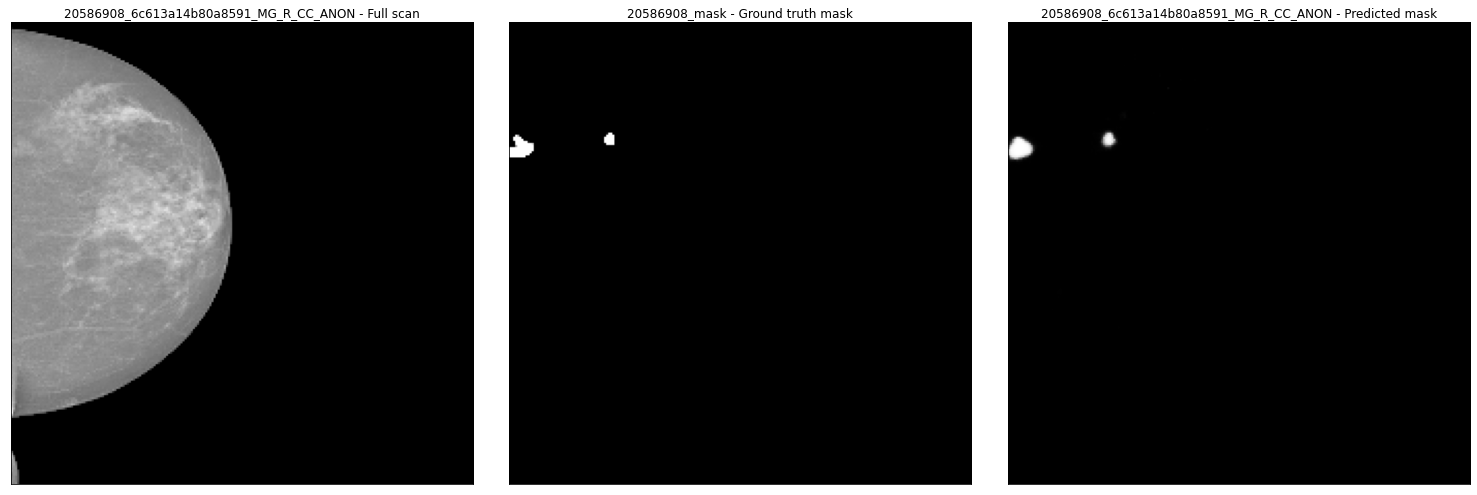

Dice  tf.Tensor(0.6522761939601288, shape=(), dtype=float64)
Jaccard  0.4725878203978788


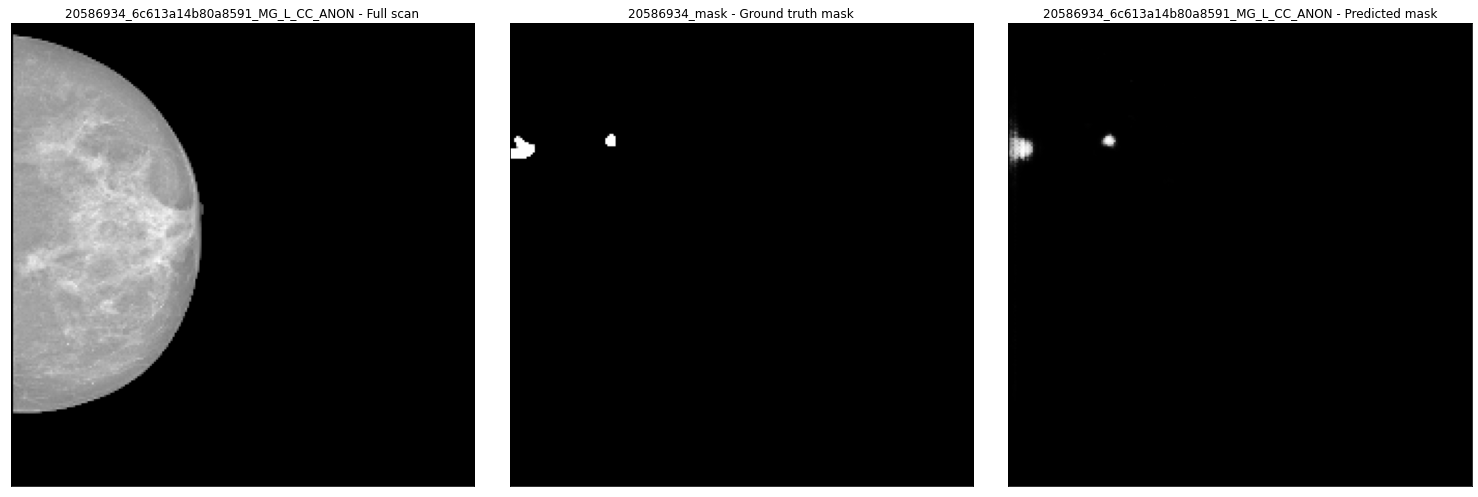

Dice  tf.Tensor(0.7517750032448792, shape=(), dtype=float64)
Jaccard  0.5875226278018704


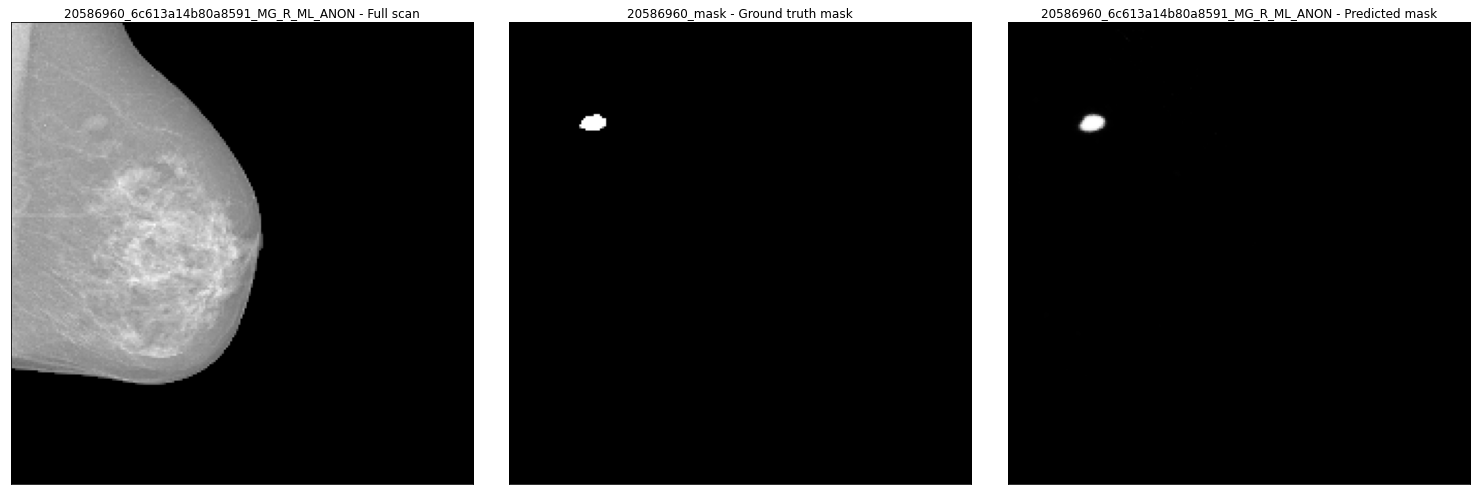

Dice  tf.Tensor(0.7368585074765474, shape=(), dtype=float64)
Jaccard  0.5743502856954882


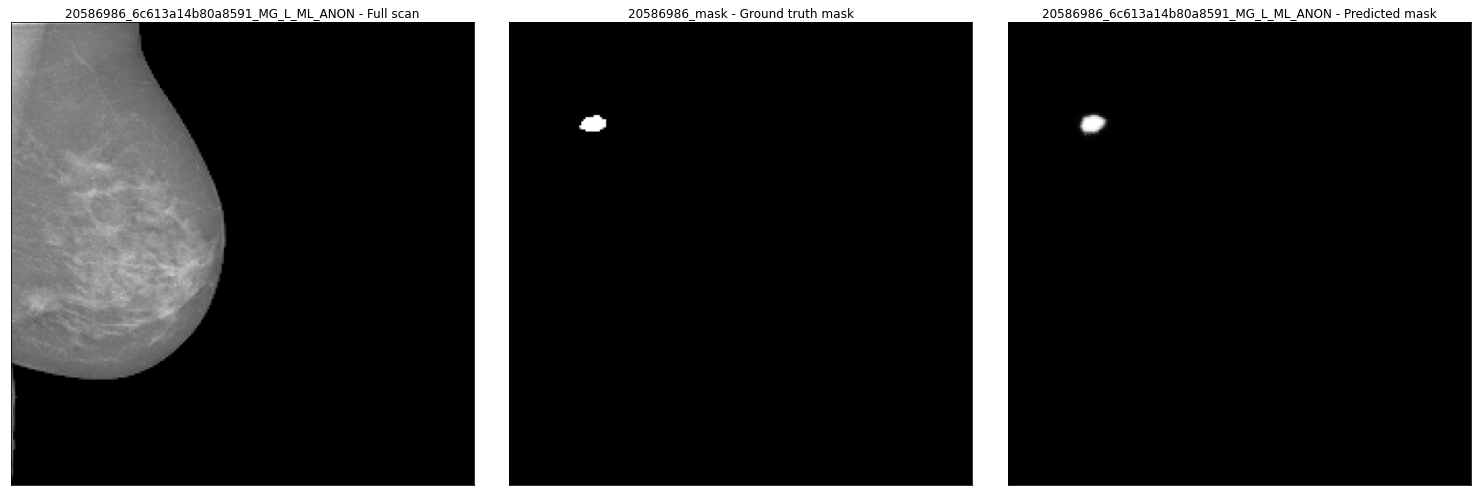

Dice  tf.Tensor(0.7770871533965891, shape=(), dtype=float64)
Jaccard  0.6052009981697469


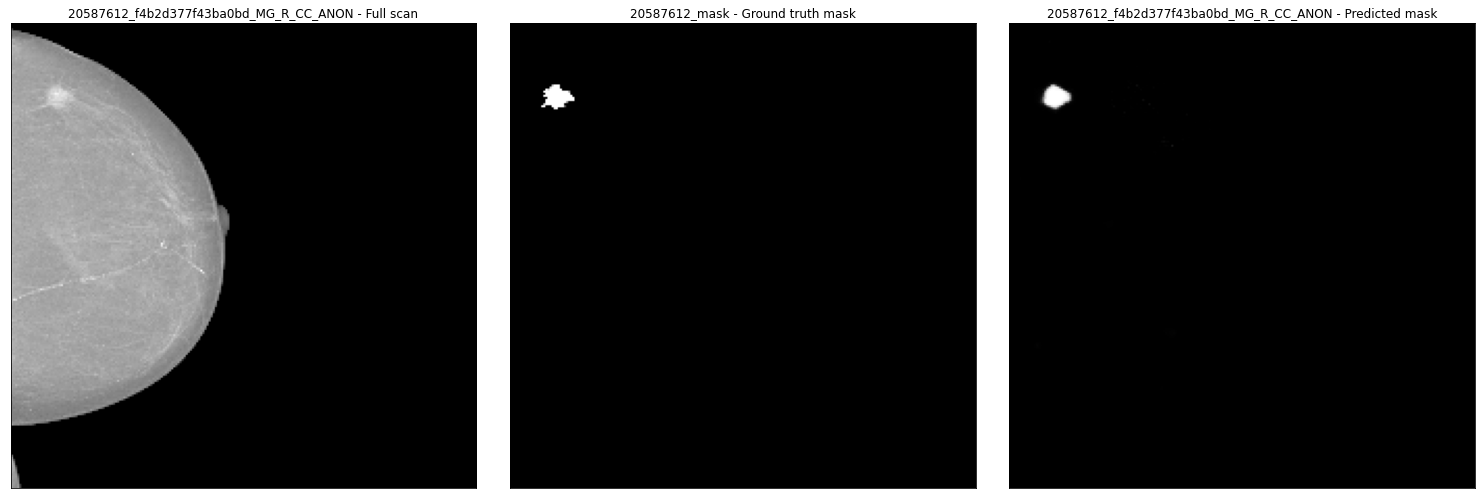

Dice  tf.Tensor(0.8125590382819253, shape=(), dtype=float64)
Jaccard  0.6645903357607794


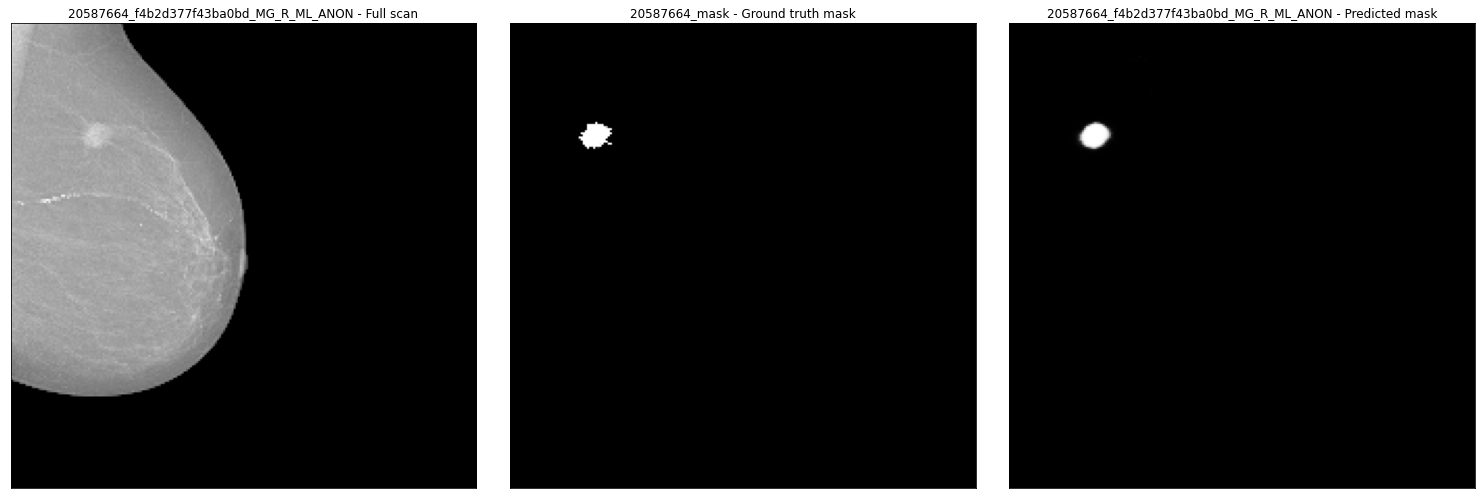

Dice  tf.Tensor(0.8085099531077468, shape=(), dtype=float64)
Jaccard  0.6565868611436603


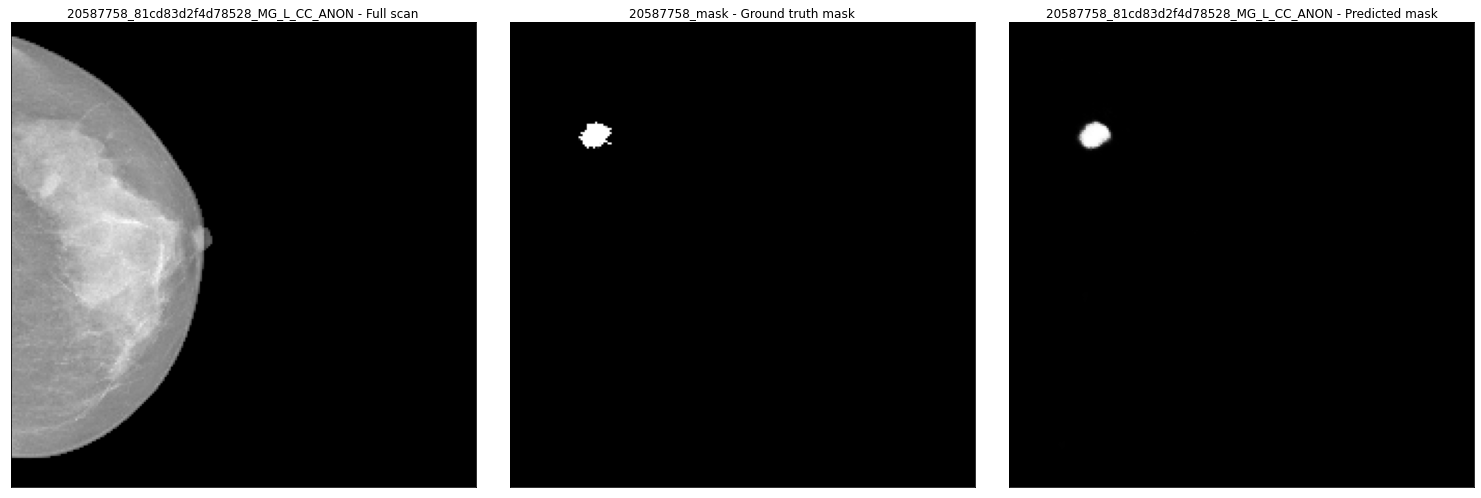

Dice  tf.Tensor(0.8105433976190924, shape=(), dtype=float64)
Jaccard  0.6583264832596104


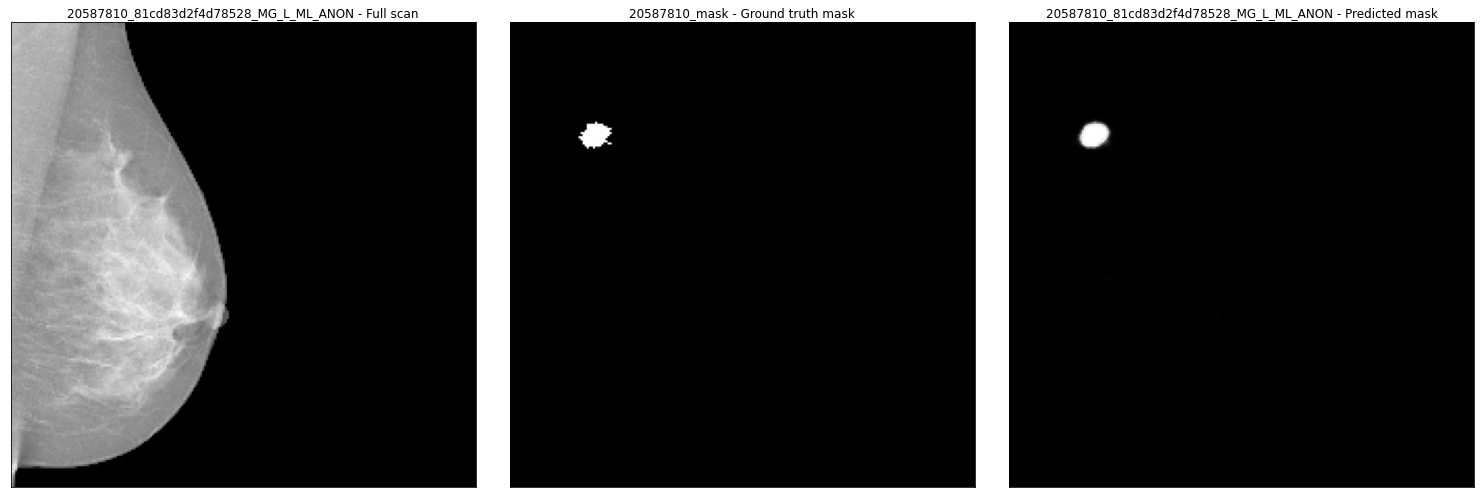

Dice  tf.Tensor(0.9598324431003172, shape=(), dtype=float64)
Jaccard  0.9174238826727746


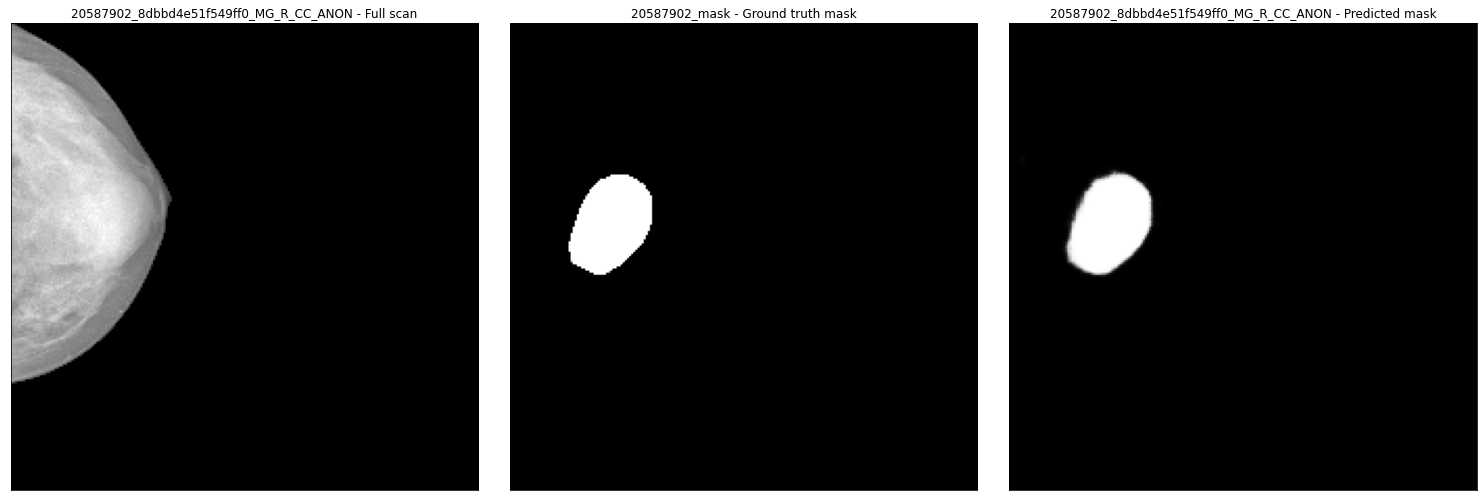

Dice  tf.Tensor(0.9684460856287009, shape=(), dtype=float64)
Jaccard  0.9368186798392346


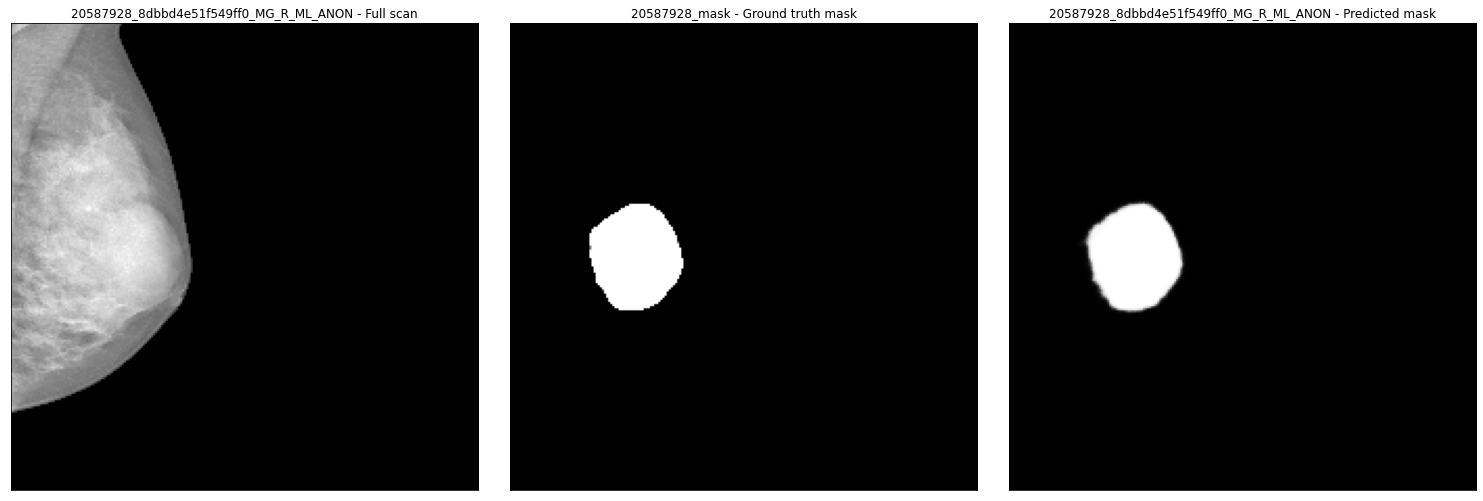

Dice  tf.Tensor(0.6304596773049645, shape=(), dtype=float64)
Jaccard  0.4343100334768218


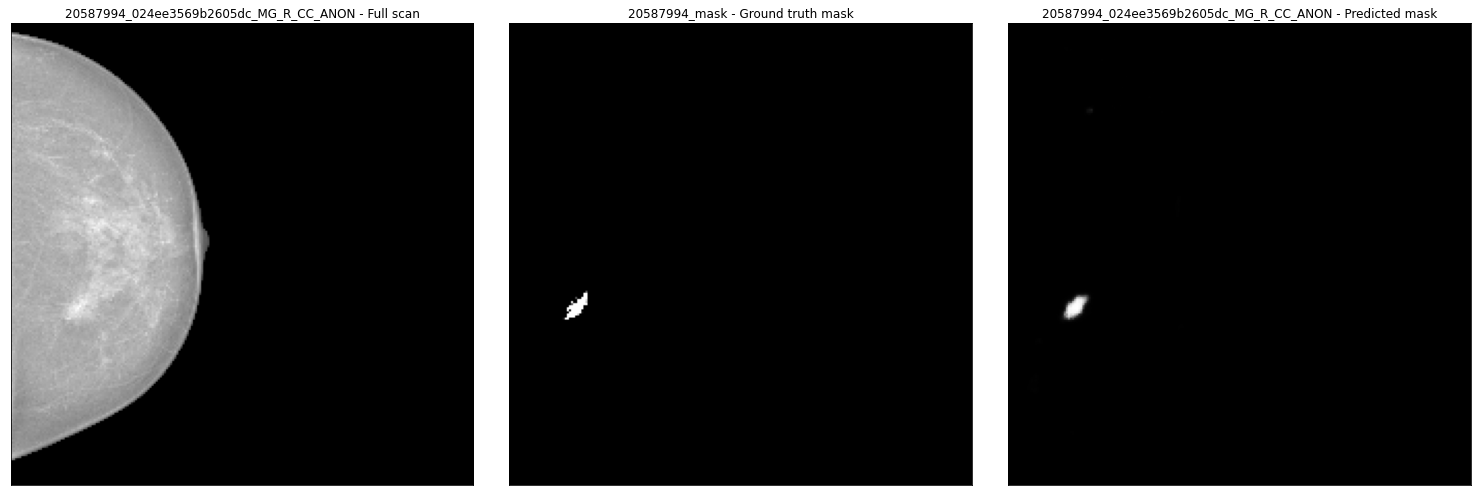

Dice  tf.Tensor(0.6779884354165477, shape=(), dtype=float64)
Jaccard  0.4955153020947585


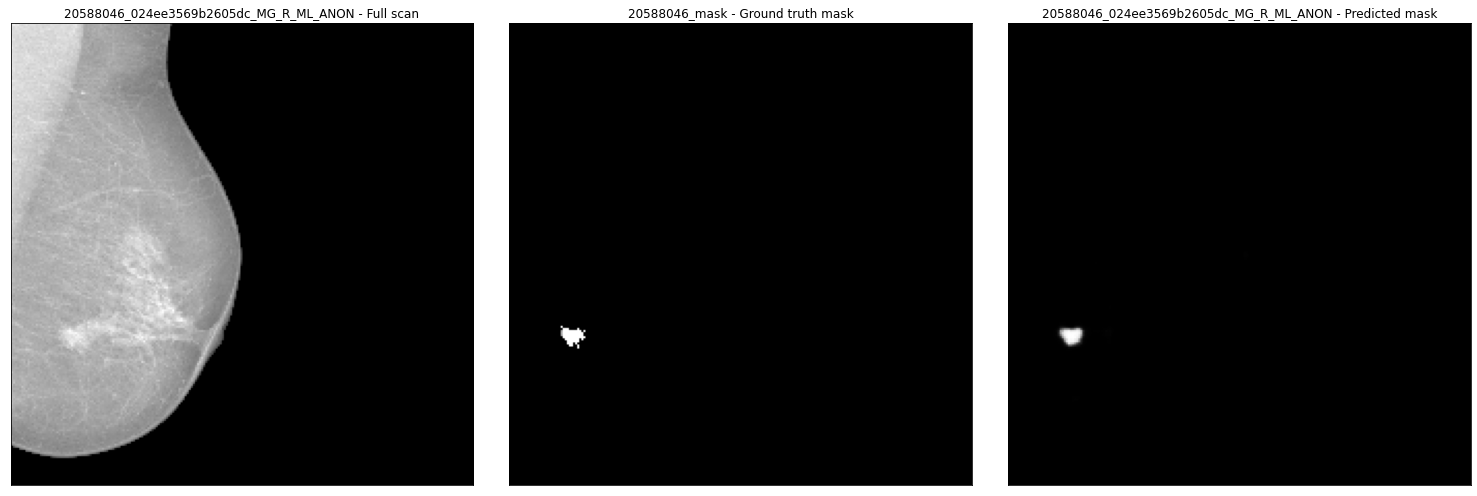

Dice  tf.Tensor(0.5011326345634061, shape=(), dtype=float64)
Jaccard  0.32970483309242865


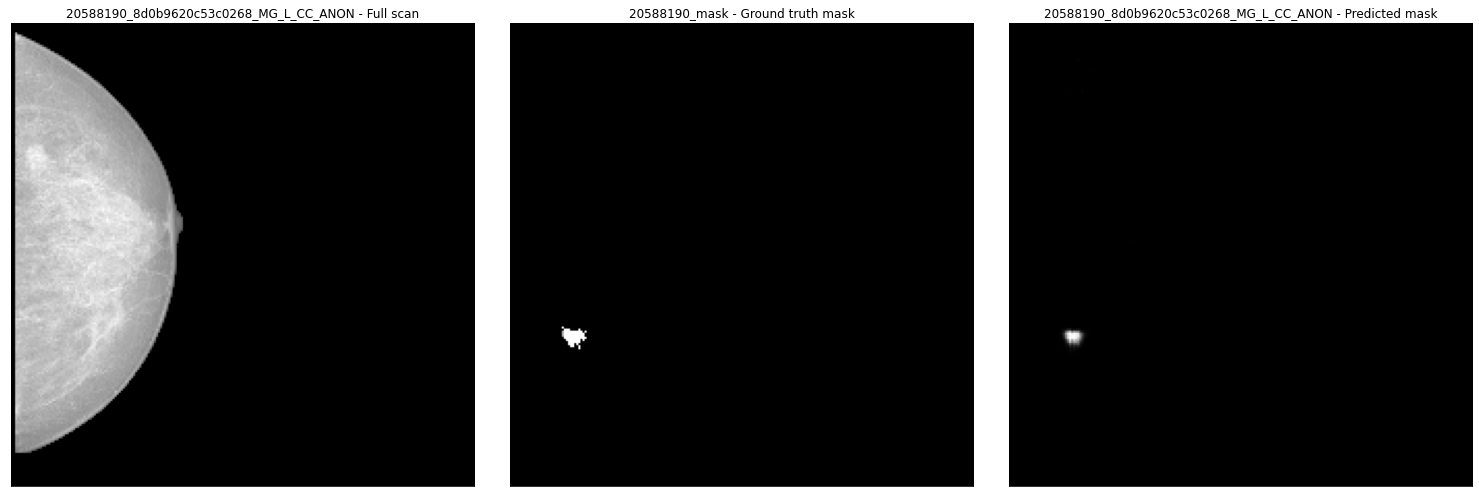

Dice  tf.Tensor(0.652164676085084, shape=(), dtype=float64)
Jaccard  0.4697132294741394


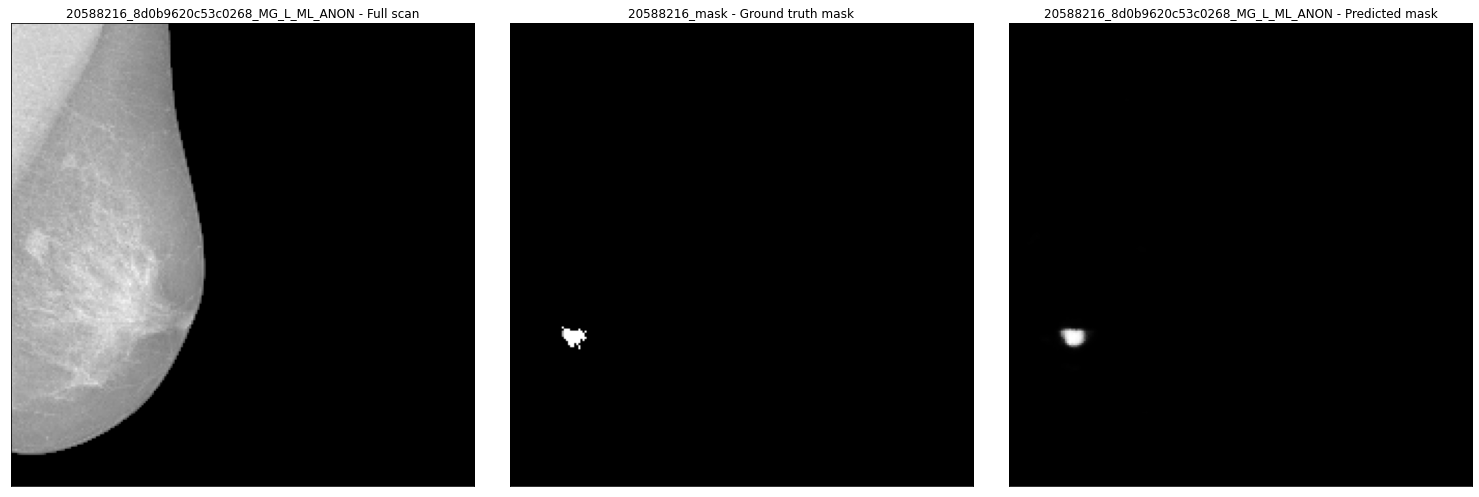

Dice  tf.Tensor(0.7009639813438887, shape=(), dtype=float64)
Jaccard  0.5212716802223696


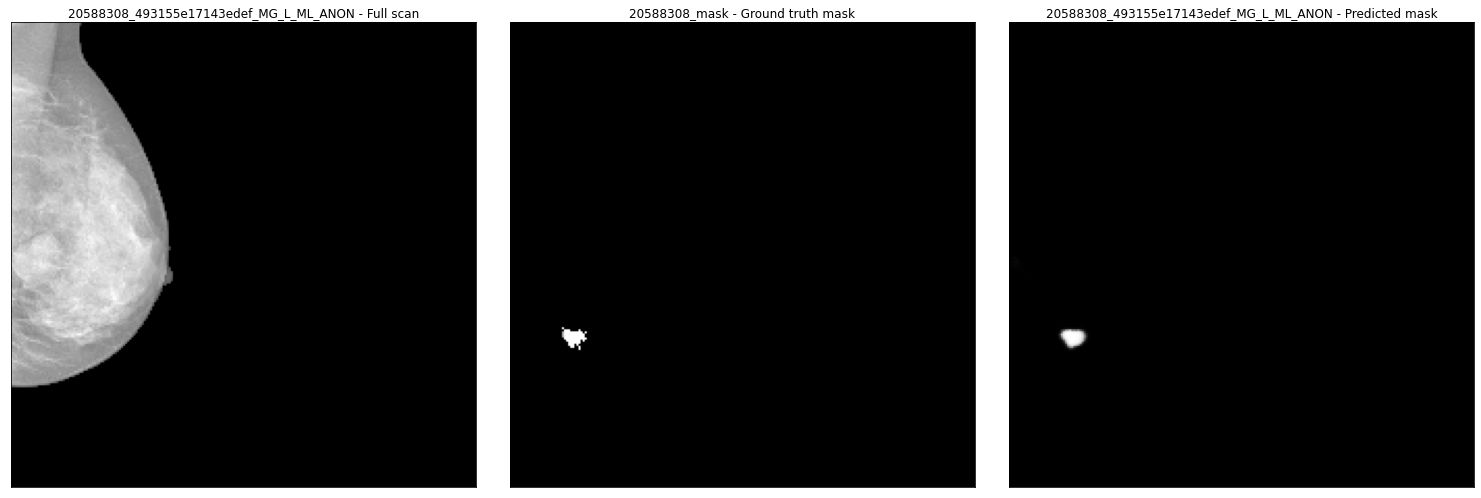

Dice  tf.Tensor(0.68414340325445, shape=(), dtype=float64)
Jaccard  0.4971967217104453


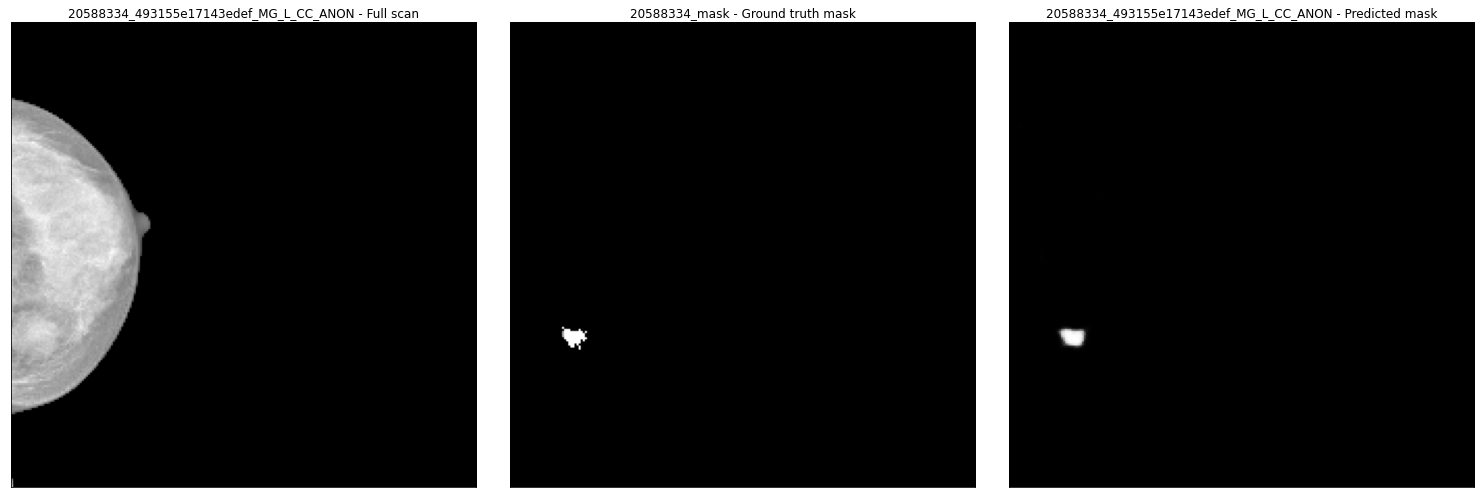

Dice  tf.Tensor(0.7140651084562213, shape=(), dtype=float64)
Jaccard  0.538785638787068


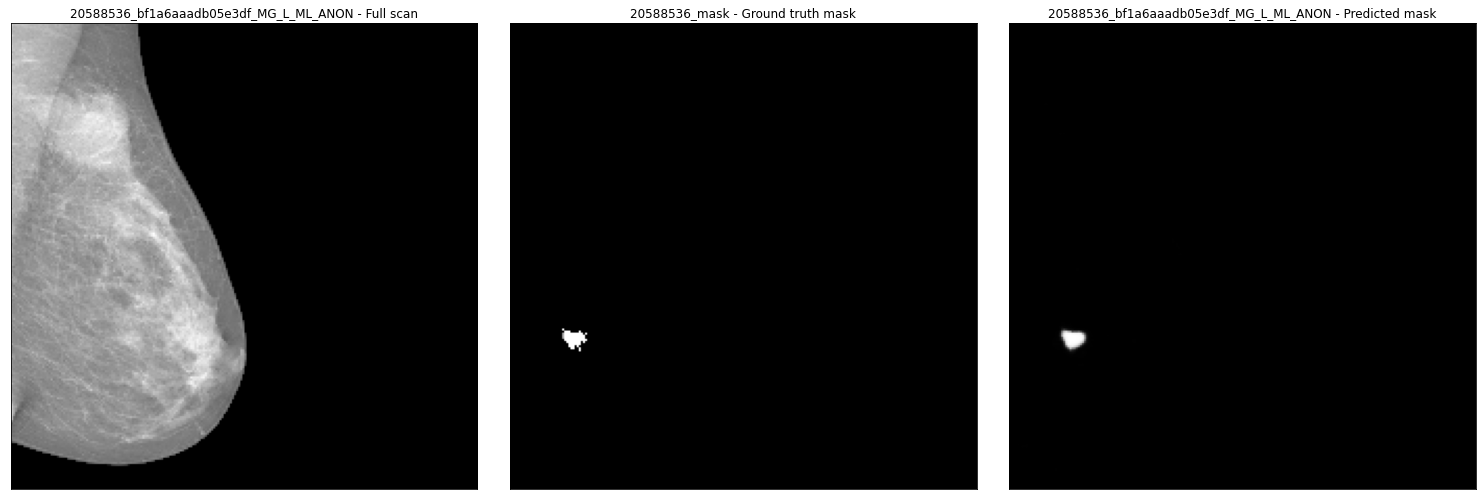

Dice  tf.Tensor(0.6911852414712875, shape=(), dtype=float64)
Jaccard  0.5096246092225003


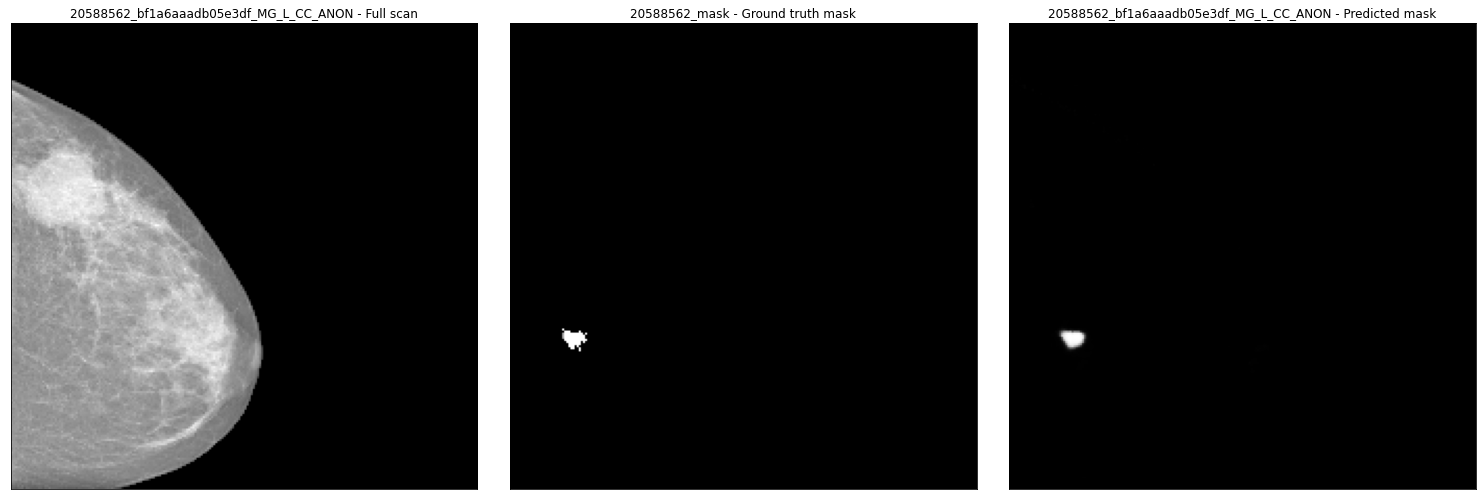

Dice  tf.Tensor(0.7036408360646317, shape=(), dtype=float64)
Jaccard  0.522895711846059


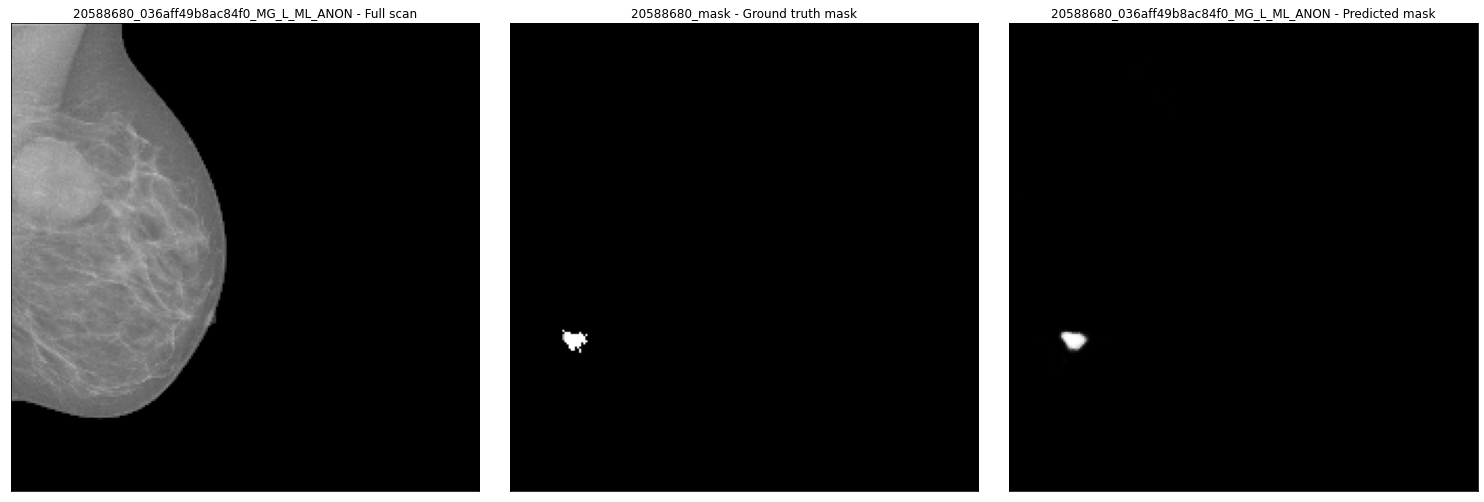

Dice  tf.Tensor(0.5810813365110687, shape=(), dtype=float64)
Jaccard  0.4019386449013867


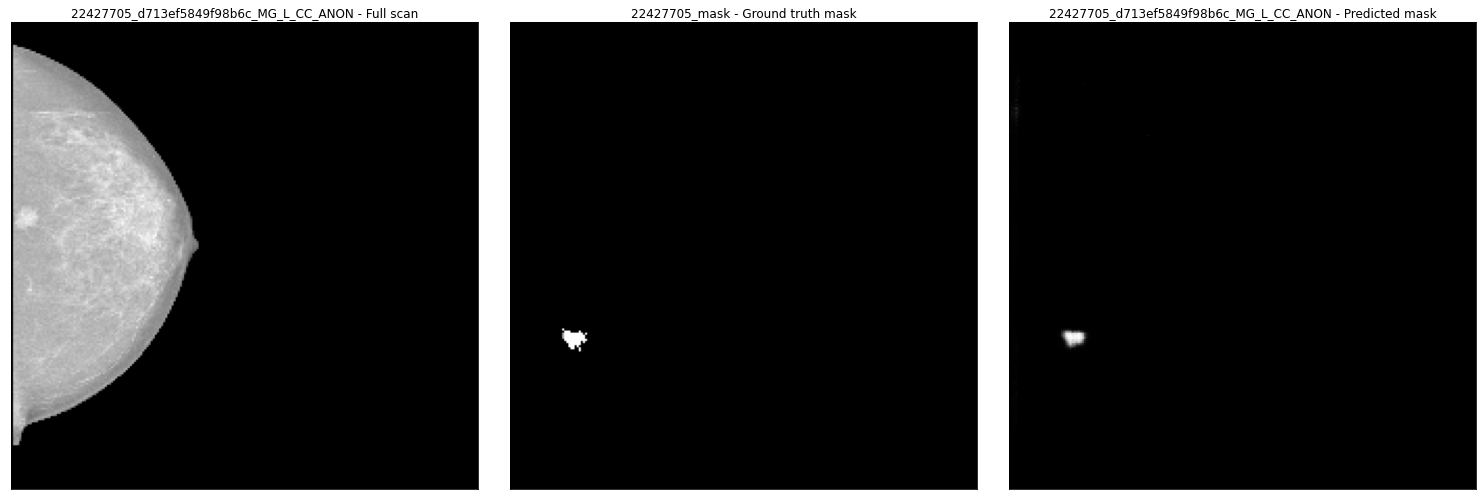

Dice  tf.Tensor(0.6907450954125196, shape=(), dtype=float64)
Jaccard  0.5080828462474877


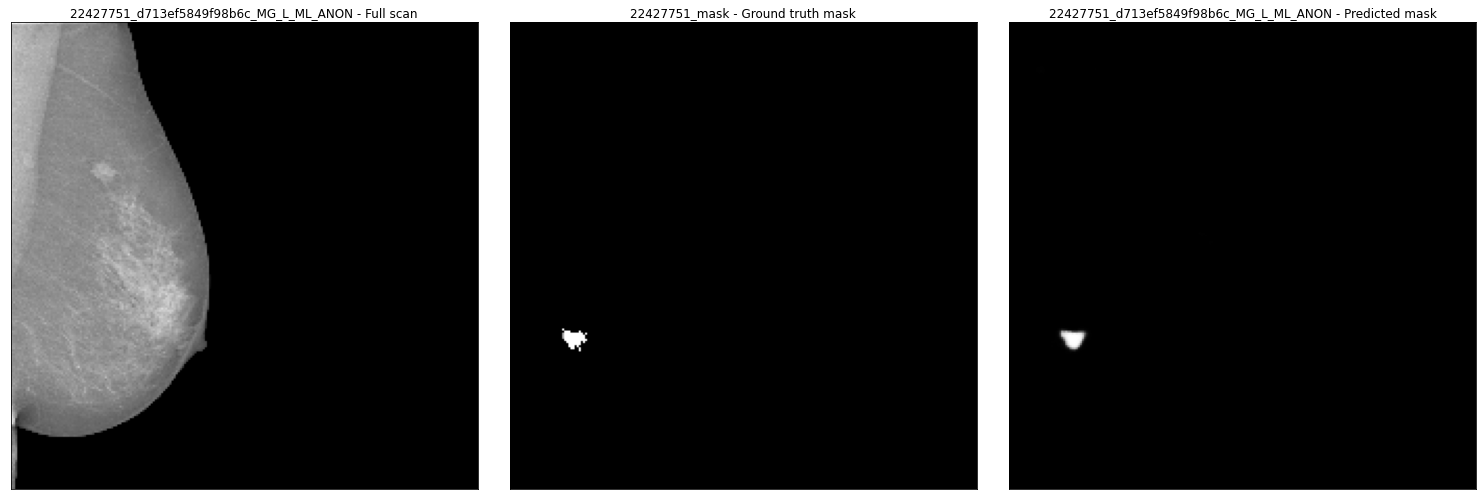

In [ ]:
#Test

test_masks_squeezed = np.squeeze(test_masks, axis = -1)
predicted_outputs_squeezed = np.squeeze(predicted_outputs, axis = -1)
predicted_outputs_squeezed = np.array(predicted_outputs_squeezed, dtype=np.float64)

dice_score_arr_test=[]
iou_score_arr_test = []

for i in range(len(predicted_outputs)):

    # =======================================
    #  Save predicted numpy arrays as images
    # =======================================

    # Get patient ID
    filename = os.path.basename(train_x[i])
    patientID = filename.replace("___PRE" + extension, "")

    p_id_mask = os.path.basename(train_y[i]).replace(extension, "")

    # Get save path
    filename_new_1 = patientID + "___PREDICTED" + extension
    filename_new_3 = patientID + "___PREDICTED_ALL" + extension
    #save_path_1 = os.path.join(save_predicted, "predmask_only", filename_new_1)
    #save_path_3 = os.path.join(
    #    save_predicted, "full_truemask_predmask", filename_new_3
    #)

    # Plot image and save
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
    ax[0].imshow(test_imgs[i], cmap="gray")
    ax[1].imshow(test_masks_squeezed[i] * 255, cmap="gray")
    ax[2].imshow(predicted_outputs_squeezed[i] * 255, cmap="gray")

    #print(predicted_outputs[i].min(), predicted_outputs[i].max())
    temp_dice = dice_coef(test_masks_squeezed[i], predicted_outputs_squeezed[i])
    #temp_dice = dice(predicted_outputs_squeezed[i], test_masks_squeezed[i], k = 1)
    temp_iou = iou(predicted_outputs_squeezed[i], test_masks_squeezed[i])
    dice_score_arr_test.append(temp_dice)
    iou_score_arr_test.append(temp_iou)
    print("Dice ", temp_dice)
    print("Jaccard ", temp_iou)

    # Set title and remove axes
    #patientID_noFULL = patientID.replace("_FULL", "")
    ax[0].set_title(f"{patientID} - Full scan")
    ax[1].set_title(f"{p_id_mask} - Ground truth mask")
    ax[2].set_title(f"{patientID} - Predicted mask")
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
#Test

test_masks_squeezed = np.squeeze(test_masks, axis = -1)
predicted_outputs_squeezed = np.squeeze(predicted_outputs, axis = -1)
predicted_outputs_squeezed = np.array(predicted_outputs_squeezed, dtype=np.float64)

In [ ]:
dice_score_arr_test=[]
iou_score_arr_test = []
haus_score_arr_test = []

for i in range(len(predicted_outputs)):

    # =======================================
    #  Save predicted numpy arrays as images
    # =======================================

    predicted_outputs_squeezed[i] = (predicted_outputs_squeezed[i] > 0.5 ) * 1

    # Get patient ID
    filename = os.path.basename(train_x[i])
    patientID = filename.replace("___PRE" + extension, "")

    p_id_mask = os.path.basename(train_y[i]).replace(extension, "")

    # Get save path
    filename_new_1 = patientID + "___PREDICTED" + extension
    filename_new_3 = patientID + "___PREDICTED_ALL" + extension
    #save_path_1 = os.path.join(save_predicted, "predmask_only", filename_new_1)
    #save_path_3 = os.path.join(
    #    save_predicted, "full_truemask_predmask", filename_new_3
    #)

    # Plot image and save
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
    ax[0].imshow(test_imgs[i], cmap="gray")
    ax[1].imshow(test_masks_squeezed[i] * 255, cmap="gray")
    ax[2].imshow(predicted_outputs_squeezed[i] * 255, cmap="gray")

    #print(predicted_outputs[i].min(), predicted_outputs[i].max())
    temp_dice = dice_coef(test_masks_squeezed[i], predicted_outputs_squeezed[i])
    #temp_dice = dice(predicted_outputs_squeezed[i], test_masks_squeezed[i], k = 1)
    temp_iou = iou(predicted_outputs_squeezed[i], test_masks_squeezed[i])
    haus_temp = directed_hausdorff(test_masks_squeezed[i], predicted_outputs_squeezed[i])
    dice_score_arr_test.append(temp_dice)
    iou_score_arr_test.append(temp_iou)
    haus_score_arr_test.append(haus_temp[0])
    print("Dice ", temp_dice)
    print("Jaccard ", temp_iou)
    print("Hausdorff: ", haus_temp)

    # Set title and remove axes
    #patientID_noFULL = patientID.replace("_FULL", "")
    ax[0].set_title(f"{patientID} - Full scan")
    ax[1].set_title(f"{p_id_mask} - Ground truth mask")
    ax[2].set_title(f"{patientID} - Predicted mask")
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
np.mean(dice_score_arr_test)

0.8843908651848386

In [ ]:
np.mean(haus_score_arr_test)

1.6785282566392172

In [ ]:
np.array(dice_score_arr_test)

array([0.9032629 , 0.87663092, 0.94764398, 0.93514912, 0.91296519,
       0.92932562, 0.93338187, 0.93644806, 0.9869888 , 0.99133911,
       0.84296314, 0.86524761, 0.61786085, 0.84902365, 0.88051182,
       0.87384793, 0.89282971, 0.88338797, 0.89767729, 0.7609133 ,
       0.85480934])

In [ ]:
np.array(haus_score_arr_test)

array([1.73205081, 1.94384843, 1.4156048 , 1.37056439, 2.03022528,
       1.42377246, 1.42377246, 1.42377246, 1.42828569, 1.41421356,
       1.45296631, 1.73205081, 2.        , 2.        , 2.        ,
       1.73205081, 1.41421356, 2.        , 1.73205081, 1.84759994,
       1.73205081])

In [ ]:
np.array(iou_score_arr_test)

array([0.81190491, 0.76968092, 0.8869348 , 0.87599187, 0.79431438,
       0.83241894, 0.83941406, 0.84422991, 0.96706865, 0.9799608 ,
       0.68295518, 0.73110005, 0.44308054, 0.72184148, 0.75642314,
       0.73202239, 0.77534206, 0.75983313, 0.78240531, 0.61141082,
       0.71636152])

## **ConnectedresUNet-Asma**

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x



def get_rwnet():    
    inputs = Input((target_size, target_size, 3))
    
    conv1 = resnet_block(inputs,32 , strides=1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = resnet_block(pool1,64 , strides=1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = resnet_block(pool2, 128, strides=1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = resnet_block(pool3, 256, strides=1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = aspp_block(pool4, 512)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = resnet_block(up6, 256, strides=1)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = resnet_block(up7, 128, strides=1)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = resnet_block(up8, 64, strides=1)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = resnet_block(up9, 32, strides=1)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)    
    conv10 = resnet_block(down10, 32, strides=1)  
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = resnet_block(down11, 64, strides=1)
    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = resnet_block(down12, 128, strides=1)
    pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), conv6], axis=3)
    conv13 = resnet_block(down13, 256, strides=1)
    pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15 = resnet_block(up15, 256, strides=1) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = resnet_block(up16, 128, strides=1)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = resnet_block(up17, 64, strides=1)   
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = resnet_block(up18, 32, strides=1)    
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    model.compile(optimizer=Adam(lr=1e-3), loss= 'binary_crossentropy', metrics=[dice_coef, jacard])
    model.summary()
    return model

connectedresunet_asma_inbreast = get_rwnet()

In [ ]:
connectedresunet_asma_inbreast.load_weights('/content/connectedresunet_asma_inbreast_epoch_60_-dice_0.43-jaccard_0.28-3rd.hdf5')

In [ ]:
connectedresunet_asma_inbreast.compile(optimizer=Adam(lr=1e-4), loss= 'binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])

In [ ]:
train_steps = len(temp_x_train) // batch_size
val_steps =  len(temp_x_val) // batch_size
test_steps = len(temp_x_test) // batch_size

if len(temp_x_train) % batch_size != 0:
    train_steps += 1
if len(temp_x_val) % batch_size != 0:
    val_steps += 1
if len(temp_x_test) % batch_size != 0:
    test_steps += 1



#loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)
#metrics=[dice_coef, jacard, iou_coef, 'accuracy']
#loss = modified_loss()
#connectedresunet_asma_inbreast.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

fname = "connectedresunet_asma_inbreast_epoch_{epoch:02d}_-dice_{val_dice_coef:.2f}-jaccard_{val_jacard:.2f}-3rd.hdf5"
model_checkpoint = ModelCheckpoint(fname, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=18, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_S = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=35)

print('-'*30)
print('Fitting connectedresunet_asma_inbreast...')
print('-'*30)

#connectedresunet_asma_inbreast.load_weights('/content/connectedresunet_asma_inbreast_20-0.23-0.12.hdf5')

history = connectedresunet_asma_inbreast.fit(train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    callbacks=[model_checkpoint, reduce_lr, early_S],
                    verbose=1
                )   


------------------------------
Fitting connectedresunet_asma_inbreast...
------------------------------
Epoch 1/200
9/9 [==============================] - 22s 1s/step - loss: 0.0055 - dice_coef: 0.8052 - jacard: 0.6768 - accuracy: 0.9980 - val_loss: 0.0307 - val_dice_coef: 0.3787 - val_jacard: 0.2388 - val_accuracy: 0.9929 - lr: 1.0000e-04
Epoch 2/200
9/9 [==============================] - 10s 1s/step - loss: 0.0051 - dice_coef: 0.7954 - jacard: 0.6673 - accuracy: 0.9981 - val_loss: 0.0285 - val_dice_coef: 0.5103 - val_jacard: 0.3603 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 3/200
9/9 [==============================] - 9s 930ms/step - loss: 0.0055 - dice_coef: 0.8204 - jacard: 0.6974 - accuracy: 0.9980 - val_loss: 0.0303 - val_dice_coef: 0.2656 - val_jacard: 0.1648 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 4/200
9/9 [==============================] - 9s 965ms/step - loss: 0.0047 - dice_coef: 0.8387 - jacard: 0.7235 - accuracy: 0.9983 - val_loss: 0.0302 - val_dice_coef: 0.4479 -

In [ ]:
connectedresunet_asma_inbreast.evaluate(test_ds, steps = test_steps)

3/3 [==============================] - 3s 585ms/step - loss: 0.0132 - dice_coef: 0.6086 - jacard: 0.4377 - accuracy: 0.9967


[0.013234593905508518,
 0.608585774898529,
 0.4376544654369354,
 0.9967215657234192]

# **ConnectedUNets++**

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x

def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''
    for i in range(length):
      if i == 0:
        shortcut = inp
        out = inp
      else: shortcut = out

      shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

      out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

      out = add([shortcut, out])
      out = Activation('relu')(out)
      out = BatchNormalization(axis=3)(out)

    return out


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out

In [ ]:
def get_rwnet_with_multitresblock_and_respath_between_encoder_decoder_and_UNets():    
    inputs = Input((target_size, target_size, 3))
    
    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    ## Mine
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    ## Mine
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    ## Mine
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    ## Mine
    mresblock4 = ResPath(32*8, 1, mresblock4)

    conv5 = aspp_block(pool4, 512)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), mresblock4], axis=3)
    conv6 = MultiResBlock(32*8, up6)
    ## Mine
    mresblock6 = ResPath(32*8, 1, conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), mresblock3], axis=3)
    conv7 = MultiResBlock(32*4, up7)
    ## Mine
    mresblock7 = ResPath(32*4, 2, conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), mresblock2], axis=3)
    conv8 = MultiResBlock(32*2, up8)
    ## Mine
    mresblock8 = ResPath(32*2, 3, conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), mresblock1], axis=3)
    conv9 = MultiResBlock(32, up9)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)  
    mresblock10 = MultiResBlock(32, down10)  
    #conv10 = resnet_block(down10, 32, strides=1)  
    pool10 = MaxPooling2D(pool_size=(2, 2))(mresblock10)
    ## Mine
    mresblock10 = ResPath(32, 4, mresblock10)

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), mresblock8], axis=3)
    mresblock11 = MultiResBlock(32*2, down11) 
    pool11 = MaxPooling2D(pool_size=(2, 2))(mresblock11)
    ## Mine
    mresblock11 = ResPath(32*2, 3, mresblock11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), mresblock7], axis=3)
    mresblock12 = MultiResBlock(32*4, down12)
    #conv12 = resnet_block(down12, 128, strides=1)
    pool12 = MaxPooling2D(pool_size=(2, 2))(mresblock12)
    ## Mine
    mresblock12 = ResPath(32*4, 2, mresblock12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), mresblock6], axis=3)
    mresblock13 = MultiResBlock(32*8, down13)
    #conv13 = resnet_block(down13, 256, strides=1)
    pool13 = MaxPooling2D(pool_size=(2, 2))(mresblock13)
    ## Mine
    mresblock13 = ResPath(32*8, 1, mresblock13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), mresblock13], axis=3)
    conv15 = MultiResBlock(32*8, up15) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), mresblock12], axis=3)
    conv16 = MultiResBlock(32*4, up16)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), mresblock11], axis=3)
    conv17 = MultiResBlock(32*2, up17)    
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), mresblock10], axis=3)
    conv18 = MultiResBlock(32, up18)  
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])
    model.summary()
    return model

connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_inbreast = get_rwnet_with_multitresblock_and_respath_between_encoder_decoder_and_UNets()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 8)  216         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 224, 224, 8)  24         ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 activation_23 (Activation)     (None, 56, 56, 71)   0           ['batch_normalization_35[0][0]'] 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 56, 56, 106)  67734       ['activation_23[0][0]']          
                                                                                                  
 batch_normalization_36 (BatchN  (None, 56, 56, 106)  318        ['conv2d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 56, 56, 106)  0           ['batch_normalization_36[0][0]'] 
                                                                                                  
 conv2d_22

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_inbreast.load_weights('/content/connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_inbreast_epoch_88_dice_0.05-iou_0.03-2nd.hdf5')

In [ ]:
connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_inbreast.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_steps = len(temp_x_train) // batch_size
val_steps =  len(temp_x_val) // batch_size
test_steps = len(temp_x_test) // batch_size

if len(temp_x_train) % batch_size != 0:
    train_steps += 1
if len(temp_x_val) % batch_size != 0:
    val_steps += 1
if len(temp_x_test) % batch_size != 0:
    test_steps += 1



#loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)
#metrics=[dice_coef, jacard, iou_coef, 'accuracy']
#loss = modified_loss()
#connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

fname = "connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_inbreast_epoch_{epoch:02d}_dice_{val_dice_coef:.2f}-iou_{val_jacard:.2f}-2nd.hdf5"
model_checkpoint = ModelCheckpoint(fname, monitor='val_loss', save_best_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=12, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_S = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

print('-'*30)
print('Fitting connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_inbreast...')
print('-'*30)

#connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256.
#load_weights('/content/connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_20-0.23-0.12.hdf5')

history = connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_inbreast.fit(train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    callbacks=[model_checkpoint, reduce_lr, early_S],
                    verbose=1,
                )   

------------------------------
Fitting connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_inbreast...
------------------------------
Epoch 1/200
9/9 [==============================] - 94s 6s/step - loss: 0.8630 - dice_coef: 0.0198 - jacard: 0.0100 - accuracy: 0.5646 - val_loss: 3.8710 - val_dice_coef: 0.0180 - val_jacard: 0.0091 - val_accuracy: 0.5959 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 14s 1s/step - loss: 0.5921 - dice_coef: 0.0201 - jacard: 0.0102 - accuracy: 0.8582 - val_loss: 2.8703 - val_dice_coef: 0.0128 - val_jacard: 0.0064 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 3/200
9/9 [==============================] - 14s 2s/step - loss: 0.4901 - dice_coef: 0.0254 - jacard: 0.0129 - accuracy: 0.9634 - val_loss: 0.2338 - val_dice_coef: 0.0127 - val_jacard: 0.0064 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 4/200
9/9 [==============================] - 14s 2s/step - loss: 0.3872 - dice_coef: 0.0276 - jacard: 0.0141 - accuracy: 0.98

In [ ]:
train_steps = (len(train_x) - val_size) // batch_size
val_steps =  val_size // batch_size
test_steps = len(test_x) // batch_size

if (len(train_x) - val_size) % batch_size != 0:
    train_steps += 1
if val_size % batch_size != 0:
    val_steps += 1
if len(test_x) % batch_size != 0:
    test_steps += 1



#loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)
#metrics=[dice_coef, jacard, iou_coef, 'accuracy']
#loss = modified_loss()
#connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

fname = "connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_epoch_{epoch:02d}_dice_{val_dice_coef:.2f}-iou_{val_jacard:.2f}-2nd.hdf5"
model_checkpoint = ModelCheckpoint(fname, monitor='val_loss', save_best_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=12, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_S = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

print('-'*30)
print('Fitting connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256...')
print('-'*30)

#connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256.
#load_weights('/content/connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256_20-0.23-0.12.hdf5')

history = connectedResUNet_with_mutiresblock_and_respath_between_encoder_decoder_and_UNets_256.fit(train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    callbacks=[model_checkpoint, reduce_lr, early_S],
                    verbose=1,
                )   

NameError: ignored

## **ConnectedResUNet with ResPath between encoder-decoder and UNets and MultiResBlock without ASPP block**

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x

def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''
    for i in range(length):
      if i == 0:
        shortcut = inp
        out = inp
      else: shortcut = out

      shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

      out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

      out = add([shortcut, out])
      out = Activation('relu')(out)
      out = BatchNormalization(axis=3)(out)

    return out


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out

In [ ]:
def get_rwnet_with_multitresblock_and_respath_between_encoder_decoder_and_UNets_without_aspp():    
    inputs = Input((target_size, target_size, 3))
    
    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    ## Mine
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    ## Mine
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    ## Mine
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    ## Mine
    mresblock4 = ResPath(32*8, 1, mresblock4)

    conv5 = MultiResBlock(32*16, pool4)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), mresblock4], axis=3)
    conv6 = MultiResBlock(32*8, up6)
    ## Mine
    mresblock6 = ResPath(32*8, 1, conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), mresblock3], axis=3)
    conv7 = MultiResBlock(32*4, up7)
    ## Mine
    mresblock7 = ResPath(32*4, 2, conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), mresblock2], axis=3)
    conv8 = MultiResBlock(32*2, up8)
    ## Mine
    mresblock8 = ResPath(32*2, 3, conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), mresblock1], axis=3)
    conv9 = MultiResBlock(32, up9)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)  
    mresblock10 = MultiResBlock(32, down10)  
    #conv10 = resnet_block(down10, 32, strides=1)  
    pool10 = MaxPooling2D(pool_size=(2, 2))(mresblock10)
    ## Mine
    mresblock10 = ResPath(32, 4, mresblock10)

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), mresblock8], axis=3)
    mresblock11 = MultiResBlock(32*2, down11) 
    pool11 = MaxPooling2D(pool_size=(2, 2))(mresblock11)
    ## Mine
    mresblock11 = ResPath(32*2, 3, mresblock11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), mresblock7], axis=3)
    mresblock12 = MultiResBlock(32*4, down12)
    #conv12 = resnet_block(down12, 128, strides=1)
    pool12 = MaxPooling2D(pool_size=(2, 2))(mresblock12)
    ## Mine
    mresblock12 = ResPath(32*4, 2, mresblock12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), mresblock6], axis=3)
    mresblock13 = MultiResBlock(32*8, down13)
    #conv13 = resnet_block(down13, 256, strides=1)
    pool13 = MaxPooling2D(pool_size=(2, 2))(mresblock13)
    ## Mine
    mresblock13 = ResPath(32*8, 1, mresblock13)
    
    conv14 = MultiResBlock(32*16, pool13)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), mresblock13], axis=3)
    conv15 = MultiResBlock(32*8, up15) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), mresblock12], axis=3)
    conv16 = MultiResBlock(32*4, up16)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), mresblock11], axis=3)
    conv17 = MultiResBlock(32*2, up17)    
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), mresblock10], axis=3)
    conv18 = MultiResBlock(32, up18)  
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    model.compile(optimizer=Adam(lr=1e-2), loss= 'binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])
    model.summary()
    return model

connectedresunetplus_without_aspp = get_rwnet_with_multitresblock_and_respath_between_encoder_decoder_and_UNets_without_aspp()

In [ ]:
train_steps = train_size // batch_size
val_steps =  val_size // batch_size
test_steps = test_size // batch_size

if train_size % batch_size != 0:
    train_steps += 1
if val_size % batch_size != 0:
    val_steps += 1
if test_size % batch_size != 0:
    test_steps += 1



#loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)
#metrics=[dice_coef, jacard, iou_coef, 'accuracy']
#loss = modified_loss()
#connectedresunetplus_without_aspp.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

fname = "connectedresunetplus_without_aspp_epoch_{epoch:02d}_-dice_{val_dice_coef:.2f}-jaccard_{val_jacard:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(fname, monitor='val_loss', save_best_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_S = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

print('-'*30)
print('Fitting connectedresunetplus_without_aspp...')
print('-'*30)

#connectedresunetplus_without_aspp.load_weights('/content/connectedresunetplus_without_aspp_20-0.23-0.12.hdf5')

history = connectedresunetplus_without_aspp.fit(train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    callbacks=[model_checkpoint, reduce_lr, early_S],
                    verbose=1
                )   
